In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL import Image

import pickle 
import cv2
from torchvision.transforms import v2
import torchxrayvision as xrv
import skimage, torch, torchvision

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_devices(gpus):
    if len(gpus) == 0:
        device_ids = None
        device = torch.device('cpu')
        print('Warning! Computing on CPU')
    elif len(gpus) == 1:
        device_ids = None
        device = torch.device('cuda:' + str(gpus[0]))
    else:
        device_ids = [int(i) for i in gpus]
        device = torch.device('cuda:' + str(min(device_ids)))
    return device, device_ids

device, device_ids = get_devices([0])

In [3]:
pathologies = np.array(["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", 
               "Lesion", "Pneumonia", "Pneumothorax", "No Finding"])

# Load generated images

In [153]:
from glob import glob

In [156]:
with open("cxr_prompt_files_base10000.pkl", "rb") as f: 
    metadata = pickle.load(f)
df = metadata['mimic']['train']

In [186]:
# df['chexpert_gen_0.7'] = np.nan
# df['nih_gen_0.7'] = np.nan
# df['padchest_gen_0.7'] = np.nan

df['chexpert_gen_0.9'] = np.nan
df['nih_gen_0.9'] = np.nan
df['padchest_gen_0.9'] = np.nan

In [189]:
datasets = ["chexpert", "nih", "padchest"] 
for dataset in datasets: 
    gen_dir = f"/mnt/scratch-lids/scratch/qixuanj/cxr_generated_images/{dataset}/inpaint/mimic/{dataset}/strength0.9"
    img_paths = glob(gen_dir + "/*.png")
    for img_path in img_paths: 
        dicom1 = img_path.split("/")[-1].split("_")[0]
        index = int(img_path.split("/")[-1].split("_img")[1].split(".")[0])
        entry = df.iloc[index]
        dicom2 = entry['file_suffix'].split('/')[-1].split(".")[0]
        assert(dicom1 == dicom2)
        df.iloc[index, df.columns.get_loc(f'{dataset}_gen_0.9')] = img_path 

In [194]:
metadata['mimic']['train'] = df

In [196]:
with open("cxr_prompt_files_base10000.pkl", "wb") as f: 
    pickle.dump(metadata, f)

In [197]:
with open("cxr_prompt_files_base10000.pkl", "rb") as f: 
    metadata = pickle.load(f)
df = metadata['mimic']['train']
df

view patientid        labels  \
0       PA  10000032    No Finding   
1       PA  10000032    No Finding   
2       AP  10000032    No Finding   
3       AP  10000032    No Finding   
4       AP  10000032    No Finding   
...    ...       ...           ...   
12981   PA  10476869                 
12982   PA  10476869                 
12983   PA  10476869                 
12984   PA  10476869    No Finding   
12985   PA  10476869  Cardiomegaly   

                                             file_suffix  age_years  \
0      p10/p10000032/s50414267/02aa804e-bde0afdd-112c...         52   
1      p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...         52   
2      p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...         52   
3      p10/p10000032/s53911762/fffabebf-74fd3a1f-673b...         52   
4      p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...         52   
...                                                  ...        ...   
12981  p10/p10476869/s57207510/bef4e780-d62c3839-c827...         57   
12982  p10/p10476869/s57266820/29b3f97c-059b2726-fac1...         57   
12983  p10/p10476869/s57266820/6c26230f-0297e51d-5092...         57   
12984  p10/p10476869/s57292220/b7c48559-6eb5f6fe-eea1...         57   
12985  p10/p10476869/s57858155/06d0887e-d1594839-946e...         57   

       sex_female  sex_male dataset_name  \
0            True     False        mimic   
1            True     False        mimic   
2            True     False        mimic   
3            True     False        mimic   
4            True     False        mimic   
...           ...       ...          ...   
12981       False      True        mimic   
12982       False      True        mimic   
12983       False      True        mimic   
12984       False      True        mimic   
12985       False      True        mimic   

                                        chexpert_gen_0.9  \
0      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
1      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
2      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
3      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
4      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
...                                                  ...   
12981  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
12982  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
12983  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
12984  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
12985  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   

                                             nih_gen_0.9  \
0      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
1      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
2      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
3      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
4      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
...                                                  ...   
12981  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
12982  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
12983  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
12984  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   
12985  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...   

                                        padchest_gen_0.9  
0      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...  
1      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...  
2      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...  
3      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...  
4      /mnt/scratch-lids/scratch/qixuanj/cxr_generate...  
...                                                  ...  
12981  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...  
12982  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...  
12983  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...  
12984  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...  
12985  /mnt/scratch-lids/scratch/qixuanj/cxr_generate...  

[9561 rows x 11 

In [202]:
pathologies = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", 
               "Lesion", "Pneumonia", "Pneumothorax", "No Finding"]

In [225]:
label_names = 'No Finding'

In [226]:
labels = np.zeros(len(pathologies))
label_indices = [i for i in range(len(pathologies)) if pathologies[i] in label_names]
labels[label_indices] = 1

In [229]:
labels

array([0., 0., 0., 0., 0., 0., 0., 1.])

In [2]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224),
                                            v2.ToDtype(torch.float32, scale=True),
                                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
                                            ])

Setting XRayResizer engine to cv2 could increase performance.


In [3]:
from cxr_dataset_gen import CXRGenDataset

In [4]:
gen_ds = CXRGenDataset(file_path="/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files", 
                      transfer_dataset="chexpert", 
                      split="gen_0.9", 
                      transform=transform)

In [5]:
print(len(gen_ds))

9561


In [6]:
gen_ds[0]

{'idx': 0,
 'img': array([[[ -586.8258 ,  -677.8896 ,  -845.63116, ...,  -951.3026 ,
           -950.87994,  -878.1314 ],
         [ -646.7977 ,  -745.2878 ,  -916.0084 , ..., -1019.8629 ,
          -1019.6041 ,  -947.5892 ],
         [ -647.78534,  -745.0916 ,  -909.7047 , ..., -1016.7188 ,
          -1016.8956 ,  -947.88324],
         ...,
         [ -715.86584,  -917.0494 ,  -989.41034, ..., -1023.7689 ,
          -1018.2376 ,  -949.48285],
         [ -682.4335 ,  -845.5293 ,  -928.33844, ..., -1023.8809 ,
          -1016.6845 ,  -948.65717],
         [ -611.50867,  -711.5427 ,  -761.79785, ...,  -949.3281 ,
           -944.9324 ,  -875.24445]]], dtype=float32),
 'lab': array([0., 0., 0., 0., 0., 0., 0., 1.])}

In [7]:
with open("split_datasets_balanced_v2.pkl", "rb") as f: 
    split_datasets = pickle.load(f)

In [8]:
split_datasets['mimic']['train'][0]

{'idx': 0,
 'lab': array([0., 0., 0., 0., 0., 0., 0., 1.]),
 'img': array([[[ -763.2016 ,  -883.5898 ,  -884.0353 , ...,  -884.0353 ,
           -883.5898 ,  -763.2016 ],
         [ -883.58984, -1022.96826, -1023.484  , ..., -1023.484  ,
          -1022.96826,  -883.58984],
         [ -884.0353 , -1023.484  , -1024.     , ..., -1024.     ,
          -1023.484  ,  -884.0353 ],
         ...,
         [ -884.0353 , -1023.484  , -1024.     , ..., -1024.     ,
          -1023.484  ,  -884.0353 ],
         [ -883.58984, -1022.96826, -1023.484  , ..., -1023.484  ,
          -1022.96826,  -883.58984],
         [ -763.2016 ,  -883.5898 ,  -884.0353 , ...,  -884.0353 ,
           -883.5898 ,  -763.2016 ]]], dtype=float32)}

# Make textual inversion datasets

In [5]:
import subprocess
import os
from tqdm import tqdm

In [6]:
out_dir = "/mnt/scratch-lids/scratch/qixuanj/inversion_datasets/cxr"

In [7]:
img_dirs = {"mimic": "/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files", 
                    "padchest": "/data/healthy-ml/gobi1/data/PadChest/images-224", 
                    "chexpert": "/data/healthy-ml/gobi1/data", 
                    "nih": "/data/healthy-ml/gobi1/data/ChestXray8/images"}

In [8]:
with open("cxr_prompt_files_base10000.pkl", "rb") as f: 
    base_prompt_file = pickle.load(f)
with open("cxr_prompt_files_transfer_seed0.pkl", "rb") as f: 
    transfer_prompt_file0 = pickle.load(f)

In [9]:
mimic = base_prompt_file['mimic']['train']

In [37]:
mimic_path = out_dir + "/mimic" 
if not os.path.exists(mimic_path): 
    os.makedirs(mimic_path)

In [38]:
for i in tqdm(range(len(mimic))):
    old_path = img_dirs['mimic'] + "/" +  mimic['file_suffix'].iloc[i]
    new_path = mimic_path + f"/image{i}.jpg"
    command = f'ln -sf {old_path} {new_path}'
    subprocess.call(command, shell=True, executable='/bin/bash',)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 9561/9561 [11:27<00:00, 13.91it/s]


In [10]:
# chexpert = transfer_prompt_file0['chexpert'][1000]['match_ds']
# chexpert_path = out_dir + "/chexpert_seed0" 

chexpert = transfer_prompt_file0['chexpert'][100]['match_ds']
chexpert_path = out_dir + "/chexpert100_seed0" 
if not os.path.exists(chexpert_path): 
    os.makedirs(chexpert_path)

In [11]:
chexpert['file_suffix'].iloc[0]

'CheXpert-v1.0-small/train/patient01362/study3/view1_frontal.jpg'

In [12]:
for i in tqdm(range(len(chexpert))):
    old_path = img_dirs['chexpert'] + "/" + chexpert['file_suffix'].iloc[i]
    new_path = chexpert_path + f"/image{i}.jpg"
    command = f'ln -sf {old_path} {new_path}'
    subprocess.call(command, shell=True, executable='/bin/bash',)

100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.55it/s]


In [13]:
# padchest = transfer_prompt_file0['padchest'][1000]['match_ds']
# padchest_path = out_dir + "/padchest_seed0" 

padchest = transfer_prompt_file0['padchest'][100]['match_ds']
padchest_path = out_dir + "/padchest100_seed0" 

if not os.path.exists(padchest_path): 
    os.makedirs(padchest_path)

In [14]:
padchest['file_suffix'].iloc[0]

'198128767781120980944971538319789797500_g549p0.png'

In [15]:
for i in tqdm(range(len(padchest))):
    old_path = img_dirs['padchest'] + "/" + padchest['file_suffix'].iloc[i]
    new_path = padchest_path + f"/image{i}.png"
    command = f'ln -sf {old_path} {new_path}'
    subprocess.call(command, shell=True, executable='/bin/bash',)

100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.11it/s]


In [16]:
# nih = transfer_prompt_file0['nih'][1000]['match_ds']
# nih_path = out_dir + "/nih_seed0" 

nih = transfer_prompt_file0['nih'][100]['match_ds']
nih_path = out_dir + "/nih100_seed0" 
if not os.path.exists(nih_path): 
    os.makedirs(nih_path)

In [17]:
nih['file_suffix'].iloc[0]

'00000054_003.png'

In [ ]:
for i in tqdm(range(len(nih))):
    old_path = img_dirs['nih'] + "/" + nih['file_suffix'].iloc[i]
    new_path = nih_path + f"/image{i}.png"
    command = f'ln -sf {old_path} {new_path}'
    subprocess.call(command, shell=True, executable='/bin/bash',)

 69%|██████████████████████████████████████████████████▎                      | 69/100 [00:02<00:01, 26.42it/s]

In [54]:
# Image.open("/mnt/scratch-lids/scratch/qixuanj/inversion_datasets/cxr/nih_seed0/image0.png")

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/IPython/core/history.py", line 581, in end_session
    self.db.execute("""UPDATE sessions SET end=?, num_cmds=? WHERE
sqlite3.OperationalError: unable to open database file


# Temp view all cxr domain classify results

In [26]:
keywords = [
    "cxr_transfer_sd_mimic_chexpert_1000_balanced",
    "cxr_transfer_sd_mimic_padchest_1000_balanced", 
    "cxr_transfer_sd_mimic_nih_1000_balanced",
    "cxr_transfer_sd_mimic_chexpert_1000_match", 
    "cxr_transfer_sd_mimic_padchest_1000_match", 
    "cxr_transfer_sd_mimic_nih_1000_match", 
    "cxr_transfer_sd_mimic_chexpert_500_match", 
    "cxr_transfer_sd_mimic_chexpert_500_balanced", 
    "cxr_transfer_sd_mimic_chexpert_100_match", 
    "cxr_transfer_sd_mimic_chexpert_100_balanced", 
    "cxr_transfer_sd_mimic_chexpert_50_match", 
    "cxr_transfer_sd_mimic_chexpert_50_balanced",
    "cxr_transfer_sd_mimic_chexpert_10_match", 
    "cxr_transfer_sd_mimic_chexpert_10_balanced", 
]

df_best = pd.DataFrame(index=keywords, columns=["best_source_acc", "best_source_checkpoint", 
                                                        "best_target_acc", "best_target_checkpoint",])
for keyword in keywords: 
    with open(f"/mnt/scratch-lids/scratch/qixuanj/{keyword}/eval/checkpoint_oracle_acc.pkl", "rb") as f: 
        results = pickle.load(f)

    checkpoints = []
    source_accs = []
    target_accs = []
    for check, dict in results.items(): 
        checkpoints.append(check)
        source_accs.append(dict['source_acc'])
        target_accs.append(dict['target_acc'])

    best_checkpoint_source = str(checkpoints[np.argmax(np.array(source_accs))])
    best_checkpoint_target = str(checkpoints[np.argmax(np.array(source_accs))])

    df_best.loc[keyword,"best_source_acc"] = np.max(np.array(source_accs))
    df_best.loc[keyword,"best_source_checkpoint"] = best_checkpoint_source
    df_best.loc[keyword,"best_target_acc"] = np.max(np.array(target_accs))
    df_best.loc[keyword,"best_target_checkpoint"] = best_checkpoint_target

In [28]:
df_best.to_csv("cxr_results/diffusion/best_transfer_checkpoints.csv")

# Debug baseline classifier training

In [18]:
output_dir = "baseline_results_new3"
seed = 0
model_name = "mimic"
epochs = 10

with open(f"{output_dir}/train/logs/{seed}/{model_name}_epoch{epochs}_val_log.pkl", "rb") as f: 
    val_log = pickle.load(f)
print(val_log)

{'auc': [0.7846646048995178, 0.7960446292245056, 0.82051791094201, 0.8342277338804286, 0.8534829265305852], 'task_aucs': [array([0.85565969, 0.8474232 , 0.82728518, 0.89335611, 0.66305497,
       0.71997121, 0.67364954, 0.79691694]), array([0.85713284, 0.84715664, 0.85056488, 0.89595672, 0.6875    ,
       0.74746312, 0.6814888 , 0.80109405]), array([0.87034907, 0.86754252, 0.88091978, 0.91137054, 0.72013742,
       0.78974451, 0.70092227, 0.82315718]), array([0.88235872, 0.87970297, 0.88719617, 0.9023918 , 0.75356765,
       0.78960058, 0.7444664 , 0.83453759]), array([0.89763735, 0.88979436, 0.9011754 , 0.91957099, 0.80245772,
       0.83332134, 0.7331357 , 0.85077054])]}


In [19]:
val_aucs = [x.item() for x in val_log['auc']]
epochs_map = np.arange(2, 11, 2)
checkpoint = str(epochs_map[np.argmax(np.array(val_aucs))])
print(checkpoint)

10


In [12]:
output_dir = "cutmix_results_new3"
seed = 0
model_name = "mimic"
epochs = 10

with open(f"{output_dir}/train/logs/{seed}/{model_name}_epoch{epochs}_val_log.pkl", "rb") as f: 
    val_log = pickle.load(f)
print(val_log)

{'auc': [0.7377564439515714, 0.6999705952410387, 0.7171472301483931, 0.764425793198233, 0.7604442007434935], 'task_aucs': [array([0.78727763, 0.81139883, 0.80623074, 0.88395976, 0.58086681,
       0.68866499, 0.57648221, 0.76717059]), array([0.74015096, 0.72468901, 0.76241013, 0.87765756, 0.48189746,
       0.6415977 , 0.62582345, 0.74553849]), array([0.71491105, 0.799213  , 0.77399292, 0.86928626, 0.56223573,
       0.59402663, 0.67285903, 0.75065323]), array([0.78969078, 0.81763138, 0.80012553, 0.87124146, 0.6515592 ,
       0.67628643, 0.72694335, 0.78192822]), array([0.75523318, 0.8217441 , 0.80286432, 0.87980258, 0.62579281,
       0.6813602 , 0.74031621, 0.77644021])]}


In [13]:
output_dir = "mixup_results_new3"
seed = 0
model_name = "mimic"
epochs = 10

with open(f"{output_dir}/train/logs/{seed}/{model_name}_epoch{epochs}_val_log.pkl", "rb") as f: 
    val_log = pickle.load(f)
print(val_log)

{'auc': [0.6815393984913762, 0.7478050485944151, 0.7390316711472329, 0.7674147073451962, 0.643936011197947], 'task_aucs': [array([0.65974522, 0.76911653, 0.79230857, 0.87959377, 0.43128964,
       0.56869377, 0.62523057, 0.72633712]), array([0.80102699, 0.81585428, 0.79801438, 0.85998481, 0.57016385,
       0.70025189, 0.68274045, 0.75440374]), array([0.81744206, 0.8254887 , 0.81804177, 0.86044039, 0.51638478,
       0.64735516, 0.65803689, 0.76906362]), array([0.76520849, 0.8318101 , 0.82774164, 0.88306758, 0.66807611,
       0.69082404, 0.69380764, 0.77878206]), array([0.66225658, 0.66171617, 0.73416638, 0.67723994, 0.59143763,
       0.53742353, 0.62233202, 0.66491584])]}


In [15]:
output_dir = "cutmix_results_alpha0.5"
seed = 0
model_name = "mimic"
epochs = 10

with open(f"{output_dir}/train/logs/{seed}/{model_name}_epoch{epochs}_val_log.pkl", "rb") as f: 
    log = pickle.load(f)
print(log)

{'auc': [0.7452906037553043, 0.7337240062862709, 0.7426730634610885, 0.72365253265782, 0.7427662921311629], 'task_aucs': [array([0.80286492, 0.80740036, 0.79333562, 0.86372437, 0.62024313,
       0.70075567, 0.61837945, 0.75562132]), array([0.77796173, 0.8185707 , 0.8401803 , 0.88234624, 0.43710359,
       0.73875495, 0.60125165, 0.77362289]), array([0.80067624, 0.78946433, 0.76731713, 0.85818147, 0.58073467,
       0.6829435 , 0.72081686, 0.74125029]), array([0.78511701, 0.79536684, 0.79190916, 0.85751708, 0.56183932,
       0.64310903, 0.59828722, 0.75607458]), array([0.73620854, 0.80327494, 0.80149492, 0.88984434, 0.63596723,
       0.64127384, 0.67094862, 0.7631179 ])]}


In [16]:
output_dir = "mixup_results_alpha0.5"
seed = 0
model_name = "mimic"
epochs = 10

with open(f"{output_dir}/train/logs/{seed}/{model_name}_epoch{epochs}_val_log.pkl", "rb") as f: 
    log = pickle.load(f)
print(log)

{'auc': [0.6655996214923812, 0.7513371819021925, 0.7381553825828919, 0.759037601000067, 0.7670465486285171], 'task_aucs': [array([0.66402436, 0.77014471, 0.66946251, 0.69832954, 0.54241543,
       0.64343289, 0.6530303 , 0.68395723]), array([0.83306443, 0.83495811, 0.82175054, 0.88756644, 0.61244715,
       0.58118028, 0.66396574, 0.77576477]), array([0.80212133, 0.83587205, 0.81849823, 0.86926727, 0.57531712,
       0.56559914, 0.65744401, 0.78112391]), array([0.71920422, 0.85124397, 0.82309141, 0.89620349, 0.62975687,
       0.69848866, 0.66719368, 0.78711851]), array([0.78663225, 0.84553186, 0.82060938, 0.88862946, 0.61905391,
       0.68359122, 0.69756258, 0.79476173])]}


# Dataset construction

In [51]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224),
                                            v2.ToDtype(torch.float32, scale=True),
                                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
                                            ])
d_chex = xrv.datasets.CheX_Dataset(imgpath="/data/healthy-ml/gobi1/data/CheXpert-v1.0-small",
                                   csvpath="/data/healthy-ml/gobi1/data/CheXpert-v1.0-small/train.csv",
                                   transform=transform, views=["PA", "AP"], unique_patients=False)
d_pc = xrv.datasets.PC_Dataset(imgpath="/data/healthy-ml/gobi1/data/PadChest/images-224", 
                               transform=transform, views=["PA", "AP"], unique_patients=False)
d_mimic = xrv.datasets.MIMIC_Dataset(imgpath="/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files", 
                                    csvpath="/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/mimic-cxr-2.0.0-chexpert.csv.gz", 
                                    metacsvpath="/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/mimic-cxr-2.0.0-metadata.csv.gz", 
                                    transform=transform, views=["AP", "PA"], unique_patients=False)
d_nih = xrv.datasets.NIH_Dataset(imgpath="/data/healthy-ml/gobi1/data/ChestXray8/images",
                                 transform=transform, views=["PA","AP"], unique_patients=False)

Setting XRayResizer engine to cv2 could increase performance.


In [52]:
# The 8 target pathologies to standardize to 
pathologies = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", 
               "Lesion", "Pneumonia", "Pneumothorax", "No Finding"]
# Standardization for NIH 
new_labels = pd.DataFrame(d_nih.labels, columns = d_nih.pathologies)
# Combine "Mass" and "Nodule" as "Lesion" class
new_labels['Lesion'] = new_labels['Mass'] + new_labels['Nodule']
new_labels['Lesion'][new_labels['Lesion'] > 1] = 1
# If all negative findings for original labels, set as no finding  
new_labels['No Finding'] = new_labels.eq(0).all(axis=1).astype(float)
d_nih.pathologies = new_labels.columns.values
d_nih.labels = new_labels.values
xrv.datasets.relabel_dataset(pathologies, d_nih)

# Standardization for PadChest 
new_labels = pd.DataFrame(d_pc.labels, columns = d_pc.pathologies) 
# Combine "Mass" and "Nodule" as "Lesion" class
new_labels['Lesion'] = new_labels['Mass'] + new_labels['Nodule']
new_labels['Lesion'][new_labels['Lesion'] > 1] = 1
no_findings_list = list(new_labels.columns)
no_findings_list.remove("Support Devices") 
no_findings_list.remove("Tube") 
print(no_findings_list)

# If all negative findings for selected labels, set as no finding  
new_labels['No Finding'] = new_labels[no_findings_list].eq(0).all(axis=1).astype(float)
d_pc.pathologies = new_labels.columns.values
d_pc.labels = new_labels.values
xrv.datasets.relabel_dataset(pathologies, d_pc)

# Standardization for CheXpert 
d_chex.pathologies = ["Lesion" if x == "Lung Lesion" else x for x in d_chex.pathologies]
new_labels = pd.DataFrame(d_chex.labels, columns = d_chex.pathologies) 
no_findings_list = list(new_labels.columns)
no_findings_list.remove("Support Devices") 
# If all negative findings for selected labels, set as no finding  
new_labels['No Finding'] = new_labels[no_findings_list].eq(0).all(axis=1).astype(float)
d_chex.pathologies = new_labels.columns.values
d_chex.labels = new_labels.values
xrv.datasets.relabel_dataset(pathologies, d_chex)

# Standardization for MIMIC-CXR 
d_mimic.pathologies = ["Lesion" if x == "Lung Lesion" else x for x in d_mimic.pathologies]
new_labels = pd.DataFrame(d_mimic.labels, columns = d_mimic.pathologies) 
no_findings_list = list(new_labels.columns)
no_findings_list.remove("Support Devices") 
print(no_findings_list)
# If all negative findings for selected labels, set as no finding  
new_labels['No Finding'] = new_labels[no_findings_list].eq(0).all(axis=1).astype(float)
d_mimic.pathologies = new_labels.columns.values
d_mimic.labels = new_labels.values
xrv.datasets.relabel_dataset(pathologies, d_mimic)

{'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Effusion', 'Hernia', 'Nodule', 'Pleural_Thickening'} will be dropped
['Air Trapping', 'Aortic Atheromatosis', 'Aortic Elongation', 'Atelectasis', 'Bronchiectasis', 'Cardiomegaly', 'Consolidation', 'Costophrenic Angle Blunting', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Flattened Diaphragm', 'Fracture', 'Granuloma', 'Hemidiaphragm Elevation', 'Hernia', 'Hilar Enlargement', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'Scoliosis', 'Tuberculosis', 'Lesion']
{'Hemidiaphragm Elevation', 'Aortic Atheromatosis', 'Emphysema', 'Flattened Diaphragm', 'Scoliosis', 'Support Devices', 'Tuberculosis', 'Fibrosis', 'Fracture', 'Infiltration', 'Mass', 'Hilar Enlargement', 'Granuloma', 'Bronchiectasis', 'Effusion', 'Air Trapping', 'Nodule', 'Hernia', 'Costophrenic Angle Blunting', 'Aortic Elongation', 'Tube', 'Pleural_Thickening'} will be dropped
{'Lung Opacity', 'Effusion', 'Enlarged Cardiomediastinum', 'Sup

In [53]:
from sklearn.model_selection import GroupShuffleSplit
# For reproducibility 
seed = 0 

max_train = 10000
max_val = 1000
max_test = 2000
original_datasets = {"mimic": d_mimic, 
                     "chexpert": d_chex, 
                     "nih": d_nih, 
                     "padchest": d_pc} 
split_datasets = {}
split_datasets_balanced = {}
gss = GroupShuffleSplit(train_size=0.8,test_size=0.2, random_state=seed)
gss_val = GroupShuffleSplit(train_size=0.875,test_size=0.125, random_state=seed)

split_ids = {}
for name, dataset in original_datasets.items(): 
    train_inds, test_inds = next(gss.split(X=range(len(dataset)), groups=dataset.csv.patientid))
    train_inds, val_inds = next(gss_val.split(X=range(len(train_inds)), groups=train_inds))

    split_datasets[name] = {}
    split_datasets[name]["train"] = xrv.datasets.SubsetDataset(dataset, train_inds)
    split_datasets[name]["val"] = xrv.datasets.SubsetDataset(dataset, val_inds)
    split_datasets[name]["test"] = xrv.datasets.SubsetDataset(dataset, test_inds)
    
    split_datasets_balanced[name] = {}
    split_datasets_balanced[name]["train"] = xrv.datasets.SubsetDataset(dataset, train_inds[:max_train])
    split_datasets_balanced[name]["val"] = xrv.datasets.SubsetDataset(dataset, train_inds[:max_val])
    split_datasets_balanced[name]["test"] = xrv.datasets.SubsetDataset(dataset, test_inds[:max_test])
    
    split_ids[name] = {}
    split_ids[name]["train"] = train_inds
    split_ids[name]["val"] = val_inds
    split_ids[name]["test"] = test_inds

In [54]:
datasets = ["mimic", "chexpert", "nih", "padchest"]

In [55]:
for d in datasets: 
    print(len(split_datasets_balanced[d]["train"]))

10000
10000
10000
10000


In [56]:
for d in datasets: 
    print(len(split_datasets_balanced[d]["val"]))

1000
1000
1000
1000


In [57]:
for d in datasets: 
    print(len(split_datasets_balanced[d]["test"]))

2000
2000
2000
2000


In [58]:
with open("split_datasets_balanced_v2.pkl", "wb") as f: 
    pickle.dump(split_datasets_balanced, f)

In [1174]:
with open("split_datasets_full.pkl", "wb") as f: 
    pickle.dump(split_datasets, f)

In [1190]:
with open("split_datasets_balanced.pkl", "wb") as f: 
    pickle.dump(split_datasets_balanced, f)

In [1197]:
with open("split_ids.pkl", "wb") as f: 
    pickle.dump(split_ids, f)

##  Generate the final transfer dataset

In [1198]:
with open("split_ids.pkl", "rb") as f: 
    split_ids = pickle.load(f)

In [1195]:
train_nums = [10, 50, 100, 250, 500, 1000]

In [1278]:
seed = 0
transfer_dataset = {}
for d in datasets: 
    transfer_dataset[d] = {}
    for train_num in train_nums: 
        train_num_each = train_num // 8
        
        transfer_dataset[d][train_num] = {}
        match_idx = pd.DataFrame(split_ids[d]['train']).sample(n=train_num, random_state=seed).values.squeeze()
        transfer_dataset[d][train_num]['match_idx'] = match_idx 
        transfer_dataset[d][train_num]['match_ds'] = xrv.datasets.SubsetDataset(original_datasets[d], match_idx)
        
        source_dataset_labels = original_datasets[d].labels[split_ids[d]['train']]
        balanced_idx = pd.DataFrame(np.argwhere(source_dataset_labels[:, 0] == 1)).sample(n=train_num_each, random_state=seed).values
        for j in range(1, 7): 
            balanced_idx = np.concatenate((balanced_idx, pd.DataFrame(np.argwhere(source_dataset_labels[:, j] == 1)).sample(n=train_num_each, 
                                                                                          random_state=seed).values))
        balanced_idx = np.concatenate((balanced_idx, 
                       pd.DataFrame(np.argwhere(source_dataset_labels[:, 7] == 1)).sample(n=train_num_each + train_num % 8, 
                                                                                          random_state=seed).values)).squeeze()
        balanced_idx = split_ids[d]['train'][balanced_idx]
        transfer_dataset[d][train_num]['balanced_idx'] = balanced_idx
        transfer_dataset[d][train_num]['balanced_ds'] = xrv.datasets.SubsetDataset(original_datasets[d], balanced_idx)

In [1268]:
transfer_dataset['chexpert'][100]['match_ds']

{'Atelectasis': {0.0: 13, 1.0: 18},
 'Cardiomegaly': {0.0: 17, 1.0: 16},
 'Consolidation': {0.0: 19, 1.0: 10},
 'Edema': {0.0: 20, 1.0: 22},
 'Lesion': {0.0: 13, 1.0: 2},
 'No Finding': {0.0: 87, 1.0: 13},
 'Pneumonia': {0.0: 15, 1.0: 2},
 'Pneumothorax': {0.0: 29, 1.0: 6}}


SubsetDataset num_samples=100
└ of CheX_Dataset num_samples=191010 views=['PA', 'AP'] data_aug=None

In [1269]:
transfer_dataset['chexpert'][100]['balanced_ds']

{'Atelectasis': {0.0: 17, 1.0: 23},
 'Cardiomegaly': {0.0: 17, 1.0: 20},
 'Consolidation': {0.0: 21, 1.0: 19},
 'Edema': {0.0: 21, 1.0: 28},
 'Lesion': {0.0: 17, 1.0: 17},
 'No Finding': {0.0: 84, 1.0: 16},
 'Pneumonia': {0.0: 16, 1.0: 12},
 'Pneumothorax': {0.0: 25, 1.0: 17}}


SubsetDataset num_samples=100
└ of CheX_Dataset num_samples=191010 views=['PA', 'AP'] data_aug=None

In [1279]:
with open("transfer_dataset_seed0.pkl", "wb") as f: 
    pickle.dump(transfer_dataset, f)

## Debug layers of Densenet121 to train 

In [45]:
model = torchvision.models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')

In [48]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_se

In [53]:
# Consist of features, then classifier
model.modules

<bound method Module.modules of DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_r

In [54]:
model.features.denseblock4

_DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm1): BatchNorm2d(544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(544, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer3): _DenseLayer(
    (norm1): BatchNorm2d(576, eps=1e-05, moment

In [51]:
model.parameters()

<generator object Module.parameters at 0x7fa7fcdf1430>

## Debug specific case

In [223]:
index = 1

In [442]:
idx, lab, img = split_datasets['chexpert']['test'][index].values()

In [443]:
conditions = ", ".join(pathologies[np.argwhere(lab == 1).squeeze()])

In [444]:
dataset_name = "chexpert"

In [445]:
curr_prompt = f"a radiograph from dataset {dataset_name} with conditions {conditions}"

In [446]:
# Convert to PIL Image for SD preprocessing 
img = img.squeeze()
img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
img = Image.fromarray(img).convert("RGB")

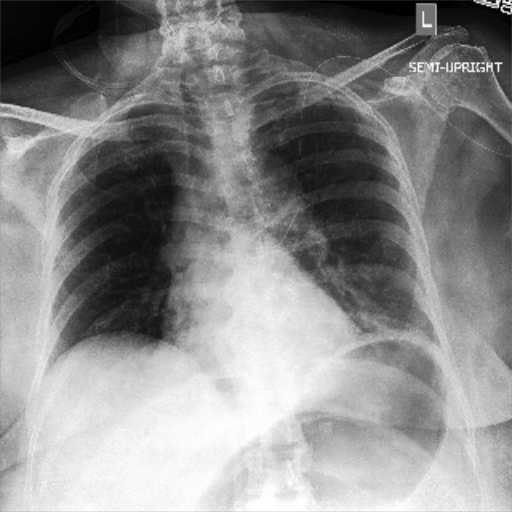

In [447]:
img

In [448]:
datasets

['mimic', 'padchest', 'chexpert', 'nih']

In [449]:
experiments = []
for d1 in datasets: 
    for d2 in datasets: 
        experiments.append((d1, d2))
experiments

[('mimic', 'mimic'),
 ('mimic', 'padchest'),
 ('mimic', 'chexpert'),
 ('mimic', 'nih'),
 ('padchest', 'mimic'),
 ('padchest', 'padchest'),
 ('padchest', 'chexpert'),
 ('padchest', 'nih'),
 ('chexpert', 'mimic'),
 ('chexpert', 'padchest'),
 ('chexpert', 'chexpert'),
 ('chexpert', 'nih'),
 ('nih', 'mimic'),
 ('nih', 'padchest'),
 ('nih', 'chexpert'),
 ('nih', 'nih')]

# Inpainting with Mask 

In [56]:
with open("cxr_prompt_files_base10000.pkl", "rb") as f: 
    metadata = pickle.load(f)
metadata = metadata['mimic']['train']

In [5]:
from CheXmask_Database.DataPostprocessing.utils import get_mask_from_RLE

In [6]:
mask_paths = {"mimic": ("dicom_id", "/data/healthy-ml/gobi1/data/chexmask-cxr-segmentation-data/0.2/Preprocessed/MIMIC-CXR-JPG.csv"), 
              "chexpert": ("Path", "/data/healthy-ml/gobi1/data/chexmask-cxr-segmentation-data/0.2/Preprocessed/CheXpert.csv"), 
              "padchest": ("ImageID", "/data/healthy-ml/gobi1/data/chexmask-cxr-segmentation-data/0.2/Preprocessed/Padchest.csv"), 
              "nih": ("Image Index", "/data/healthy-ml/gobi1/data/chexmask-cxr-segmentation-data/0.2/OriginalResolution/ChestX-Ray8.csv")}

In [7]:
df_mask = pd.read_csv("/data/healthy-ml/gobi1/data/chexmask-cxr-segmentation-data/0.2/Preprocessed/MIMIC-CXR-JPG.csv")
df_mask

dicom_id  Dice RCA (Mean)  \
0       f4a185f1-db2de1fd-a05b274e-21f07d10-63a30841         0.885982   
1       1534c820-a44d5232-30d7c596-ca557ed1-ef14d4ae         0.866419   
2       95aa18d9-27969db3-9c904c3b-7e6eb3fa-95ee0061         0.884501   
3       80321566-1d300fe2-358ad58a-98a6b6d2-d7ad6c3f         0.864541   
4       a9a74a32-490cae66-d7a2fd39-cab8a408-858f665b         0.876013   
...                                              ...              ...   
243329  21570ef0-ba470921-6e936b78-2e46f17e-31c6cc51         0.862717   
243330  c2714aec-df227cb9-c87c3261-5526f21e-b67883dd         0.873246   
243331  d5fd7e0c-5961fd50-cc03a030-723ee3fb-048b7fda         0.868462   
243332  1dede0f2-fe40a0db-5fb8d85a-81dbbfc0-5fedf7cf         0.878087   
243333  c7d10e39-e54e6b6c-2fd98318-a8d1e6c8-df295d15         0.842991   

        Dice RCA (Max)                                          Landmarks  \
0             0.910834  412,138,392,141,369,157,342,179,317,202,296,23...   
1             0.928404  457,62,418,65,380,80,342,103,313,131,291,164,2...   
2             0.905510  397,143,375,146,352,163,327,187,302,211,280,24...   
3             0.897160  372,169,350,168,326,186,301,212,281,239,267,27...   
4             0.908857  380,161,353,165,326,185,298,210,273,238,251,26...   
...                ...                                                ...   
243329        0.922274  472,174,441,178,410,193,378,212,349,233,324,25...   
243330        0.906061  395,169,364,174,334,190,304,208,279,228,257,25...   
243331        0.881600  397,197,373,197,350,206,323,219,299,233,279,25...   
243332        0.890184  371,192,346,194,318,207,289,224,263,246,241,27...   
243333        0.886001  502,195,473,198,443,211,413,232,386,258,363,28...   

                                                Left Lung  \
0       142956 8 143968 23 144985 32 146007 37 147029 ...   
1       72383 39 73405 43 74427 48 75449 52 76470 58 7...   
2       126573 4 127593 13 128614 21 129634 30 130655 ...   
3       175716 15 176725 32 177748 35 178770 39 179793...   
4       163435 4 164455 11 165474 20 166493 28 167513 ...   
...                                                   ...   
243329  186054 8 187065 25 188082 36 189104 42 190126 ...   
243330  185985 9 186995 29 188012 42 189034 50 190056 ...   
243331  219745 7 220766 21 221787 31 222808 36 223830 ...   
243332  196195 8 197205 25 198222 35 199244 40 200267 ...   
243333  206547 15 207558 32 208580 38 209603 43 210625...   

                                               Right Lung  \
0       141722 5 142740 13 143757 22 144777 28 145799 ...   
1       63940 8 64951 24 65962 40 66978 51 68000 56 69...   
2       146827 5 147844 14 148860 24 149880 30 150902 ...   
3       172383 12 173406 24 174428 28 175451 31 176474...   
4       165242 5 166259 14 167277 23 168294 32 169314 ...   
...                                                   ...   
243329  178646 5 179662 17 180678 29 181694 41 182713 ...   
243330  173449 6 174467 16 175485 27 176503 38 177521 ...   
243331  202101 27 203123 32 204144 39 205166 44 206187...   
243332  196974 8 197986 23 199002 35 200024 40 201046 ...   
243333  200179 7 201193 21 202207 36 203225 46 204247 ...   

                                                    Heart  Height  Width  
0       413195 10 414212 31 415229 47 416246 58 417265...    1024   1024  
1       376369 23 377372 52 378394 62 379416 72 380437...    1024   1024  
2       438785 45 439794 68 440814 77 441834 82 442854...    1024   1024  
3       496113 16 497129 51 498144 61 499162 68 500184...    1024   1024  
4       481795 19 482804 46 483824 58 484844 68 485864...    1024   1024  
...                                                   ...     ...    ...  
243329  399947 9 400963 27 401979 44 402995 60 404013 ...    1024   1024  
243330  386616 12 387623 31 388637 42 389651 53 390667...    1024   1024  
243331  379371 7 380391 21 381411 33 382432 41 383452 ...    1024   1024  
243332  445922 34 446941 5

In [8]:
mimic_base_dir = "/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files"

In [86]:
i = 5
img_path = mimic_base_dir + "/" + metadata['file_suffix'].iloc[i]
img = Image.open(img_path).convert("RGB")

conditions = metadata['labels'].iloc[i]
uniq_id = img_path.split("/")[-1].split(".")[0]
example = df_mask[df_mask[mask_paths["mimic"][0]] == uniq_id]

In [87]:
height = example["Height"].iloc[0]
width = example["Width"].iloc[0]
rightLungMask_RLE = example["Right Lung"].iloc[0]
leftLungMask_RLE = example["Left Lung"].iloc[0]
heartMask_RLE = example["Heart"].iloc[0]

rightLungMask = get_mask_from_RLE(rightLungMask_RLE, height, width)
leftLungMask = get_mask_from_RLE(leftLungMask_RLE, height, width)
heartMask = get_mask_from_RLE(heartMask_RLE, height, width)

rightLungMask_resized = cv2.resize(rightLungMask, (512, 512), interpolation =cv2.INTER_NEAREST)
leftLungMask_resized = cv2.resize(leftLungMask, (512, 512), interpolation =cv2.INTER_NEAREST)
heartMask_resized = cv2.resize(heartMask, (512, 512), interpolation =cv2.INTER_NEAREST)
combined_mask = rightLungMask_resized | leftLungMask_resized | heartMask_resized
inv_mask = np.invert(combined_mask)

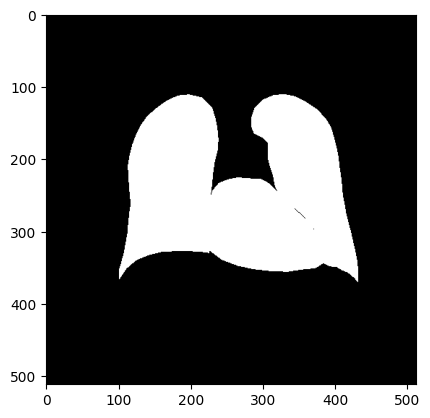

In [88]:
plt.imshow(combined_mask, cmap='gray')

In [89]:
inv_mask = np.invert(combined_mask)

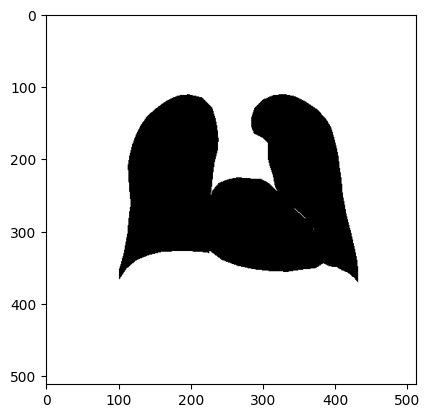

In [90]:
mask_mod = Image.fromarray(np.uint8(inv_mask)).convert("L")
plt.imshow(mask_mod, cmap='gray')

In [15]:
from diffusers import StableDiffusionInpaintPipeline
from diffusers import UNet2DConditionModel

In [16]:
generator = torch.Generator("cuda").manual_seed(0)

In [97]:
model_path = "runwayml/stable-diffusion-v1-5"
# target = "chexpert"
# file_prefix = "/mnt/scratch-lids/scratch/qixuanj/dreambooth/cxr_transfer_sd_mimic_chexpert_1000_match_checkpoint-400/chexpert/checkpoint-1000"
# target = "nih"
# file_prefix = "/mnt/scratch-lids/scratch/qixuanj/dreambooth/cxr_transfer_sd_mimic_nih_1000_match_checkpoint-200/nih/checkpoint-1000"
target = "padchest" 
file_prefix = "/mnt/scratch-lids/scratch/qixuanj/dreambooth/cxr_transfer_sd_mimic_padchest_1000_match_checkpoint-600/padchest/checkpoint-200"

unet = UNet2DConditionModel.from_pretrained(f"{file_prefix}/unet", torch_dtype=torch.bfloat16,)

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    unet=unet,
    torch_dtype=torch.bfloat16,
    safety_checker=None,
)

pipe = pipe.to("cuda")
pipe.enable_model_cpu_offload()

Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


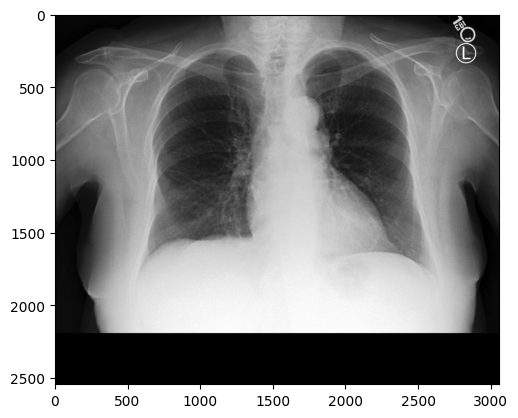

In [91]:
plt.figure()
plt.imshow(img)
plt.show()

In [98]:
new_prompt = f"a radiograph from dataset {target} with conditions {conditions}"
# new_prompt = f"a radiograph from dataset {target} with conditions "

In [99]:
new_prompt

'a radiograph from dataset padchest with conditions No Finding'

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 18.93it/s]


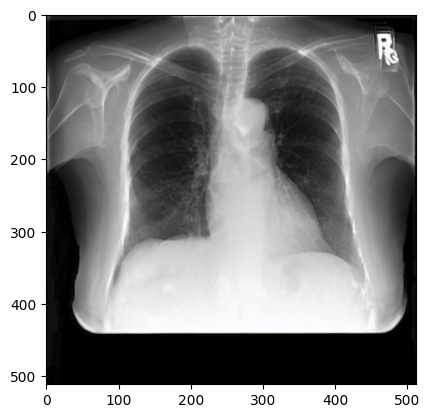

In [100]:
image = pipe(prompt=new_prompt, 
         image=img, 
         mask_image=mask_mod, 
         strength=0.7,
         guidance_scale=15,
         num_inference_steps=50, 
         generator=generator, 
         # num_images_per_prompt=5,
        ).images[0]
plt.imshow(image)
plt.show()
# for j, image in enumerate(image.images): 
#     plt.title(f"img{j}")
#     plt.imshow(image)
#     plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 19.90it/s]


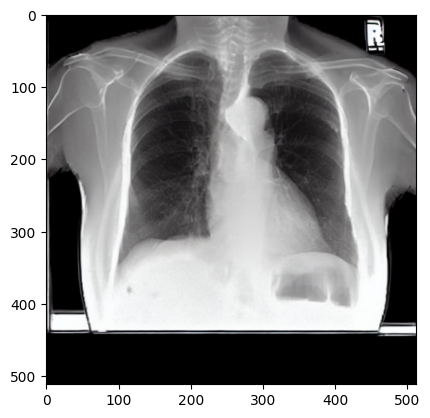

In [101]:
image = pipe(prompt=new_prompt, 
         image=img, 
         mask_image=mask_mod, 
         strength=0.9,
         guidance_scale=15,
         num_inference_steps=50, 
         generator=generator, 
         # num_images_per_prompt=5,
            ).images[0]
plt.imshow(image)
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.20it/s]


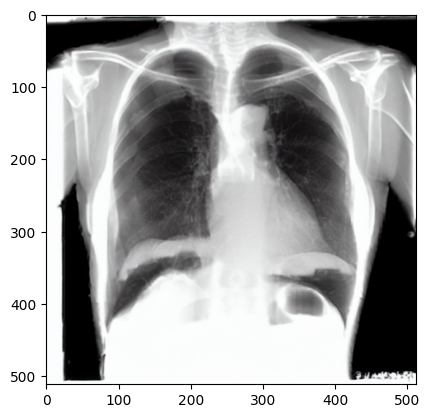

In [102]:
image = pipe(prompt=new_prompt, 
         image=img, 
         mask_image=mask_mod, 
         strength=1.0,
         guidance_scale=15,
         num_inference_steps=50, 
         generator=generator, 
         # num_images_per_prompt=5,
            ).images[0]
plt.imshow(image)
plt.show()

In [68]:
from skimage.metrics import structural_similarity

In [149]:
img_gray = cv2.cvtColor(np.array(img.resize((512, 512))), cv2.COLOR_BGR2GRAY)
# img_gray = img_gray.resize((512, 512))
image_gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

In [150]:
(score, diff) = structural_similarity(img_gray, image_gray, full=True)
print("Image Similarity: {:.4f}%".format(score * 100))

Image Similarity: 71.9141%


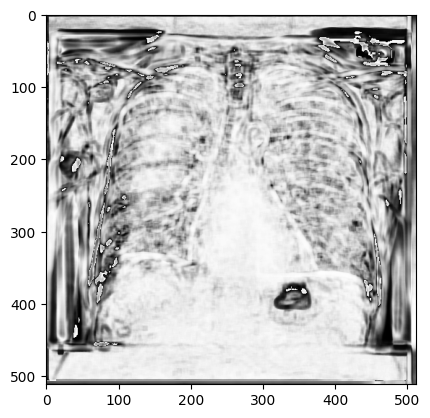

In [151]:
diff = (diff * 255).astype("uint8")
plt.imshow(diff, cmap='gray')
plt.show()

# Img2Img Baseline

In [135]:
from diffusers import StableDiffusionImg2ImgPipeline

In [136]:
model_path = "runwayml/stable-diffusion-v1-5"
target = "padchest" 
file_prefix = "/mnt/scratch-lids/scratch/qixuanj/dreambooth/cxr_transfer_sd_mimic_padchest_1000_match_checkpoint-600/padchest/checkpoint-200"

unet = UNet2DConditionModel.from_pretrained(f"{file_prefix}/unet", 
                                            torch_dtype=torch.bfloat16,)

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    unet=unet,
    torch_dtype=torch.bfloat16,
)

pipe = pipe.to(device)

Loading pipeline components...: 100%|████████████████████████████████████████████| 7/7 [00:01<00:00,  5.72it/s]


In [137]:
new_prompt = f"a radiograph from dataset {target} with conditions {conditions}"

100%|██████████████████████████████████████████████████████████████████████████| 15/15 [01:19<00:00,  5.29s/it]


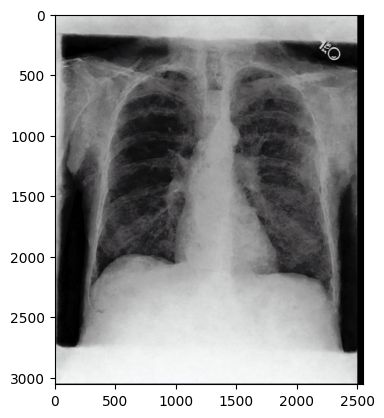

In [141]:
image = pipe(prompt=new_prompt, 
             image=img,
             strength=0.3,
             guidance_scale=7.5,
             num_inference_steps=50, 
             generator=generator).images[0]

plt.figure()
plt.imshow(image)

100%|██████████████████████████████████████████████████████████████████████████| 25/25 [02:05<00:00,  5.02s/it]


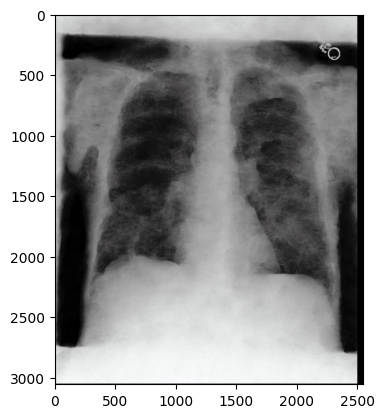

In [138]:
image = pipe(prompt=new_prompt, 
             image=img,
             strength=0.5,
             guidance_scale=7.5,
             num_inference_steps=50, 
             generator=generator).images[0]

plt.figure()
plt.imshow(image)

100%|██████████████████████████████████████████████████████████████████████████| 35/35 [02:55<00:00,  5.01s/it]


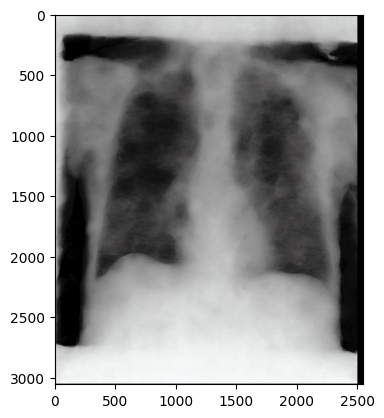

In [140]:
image = pipe(prompt=new_prompt, 
             image=img,
             strength=0.7,
             guidance_scale=7.5,
             num_inference_steps=50, 
             generator=generator).images[0]

plt.figure()
plt.imshow(image)

In [381]:
img_gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
image_gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

In [382]:
(score, diff) = structural_similarity(img_gray, image_gray, full=True)
print("Image Similarity: {:.4f}%".format(score * 100))

Image Similarity: 84.8858%


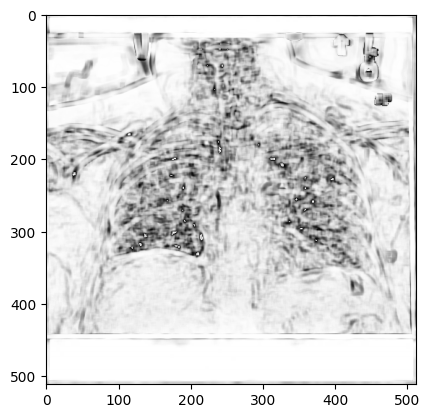

In [383]:
diff = (diff * 255).astype("uint8")
plt.imshow(diff, cmap='gray')
plt.show()

# Crop to masked region

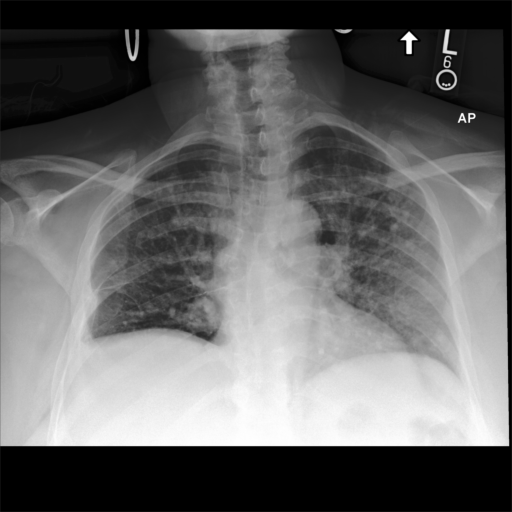

In [439]:
img

In [467]:
combined_mask

(512, 512)

In [468]:
# cropping code 
threshold = 0.5
xmin,ymin,xmax,ymax = (-1,-1,-1,-1)
for j in range(512):
    for i in range(512):
        if combined_mask[j,i] <= threshold: continue
        xmin = i if xmin == -1 or xmin > i else xmin
        xmax = i if xmax == -1 or xmax < i else xmax
        ymin = j if ymin == -1 or ymin > j else ymin
        ymax = j if ymax == -1 or ymax < j else ymax

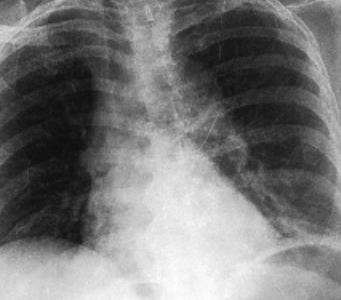

In [470]:
# Can crop 
img.crop((xmin, ymin, xmax, ymax))

# CutMix or MixUp

In [539]:
dataloader = torch.utils.data.DataLoader(split_datasets['chexpert']['test'], batch_size=8, shuffle=False)

In [547]:
def torchxrayvision_numpy_to_pil(img): 
    img = img.squeeze()
    img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    return Image.fromarray(img).convert("RGB")

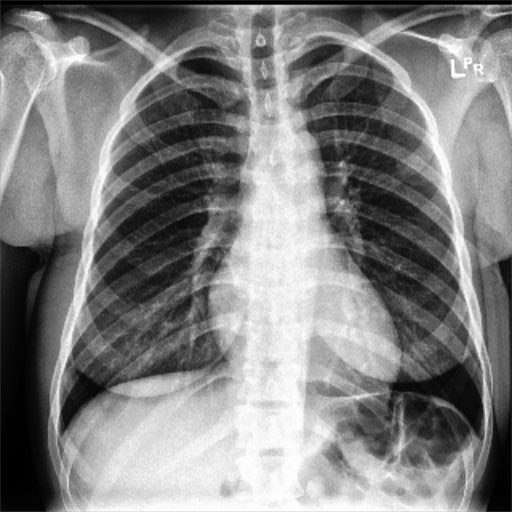

In [549]:
torchxrayvision_numpy_to_pil(split_datasets['chexpert']['test'][0]['img'])

In [485]:
from torchvision.transforms import v2

In [540]:
NUM_CLASSES = 8
cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)

In [ ]:
'''
Other augmentations implemented: 
v2.RandAugment
v2.AutoAugment
'''

Before CutMix: images.shape = torch.Size([8, 1, 512, 512]), converted_labels.shape = torch.Size([8])


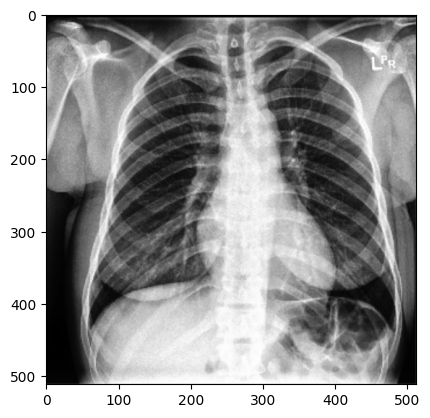

After CutMix: images.shape = torch.Size([8, 1, 512, 512]), converted_labels.shape = torch.Size([8, 8])


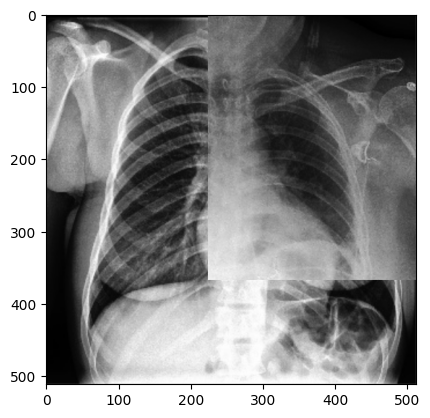

In [554]:
# CutMix implement as part of torchvision augmentations
for batch in dataloader:
    images = batch['img']
    labels = batch['lab']
    pos_idx = np.argwhere(labels == 1)
    pos_idx = pd.DataFrame(pos_idx).T
    pos_idx = pos_idx.groupby(0).apply(lambda x: x.sample(1, random_state=0)).reset_index(drop=True)
    converted_labels = pd.DataFrame(index=range(8), columns = ["lab"])
    converted_labels.loc[pos_idx[0], "lab"] = pos_idx[1]
    # Fill in as No Finding 
    converted_labels = torch.from_numpy(converted_labels.fillna(7).values.squeeze()).to(torch.int64)
    
    print(f"Before CutMix: {images.shape = }, {converted_labels.shape = }")
    plt.imshow(torchxrayvision_numpy_to_pil(np.array(images[0, :])), cmap='gray')
    plt.show()
    
    
    images, converted_labels = cutmix(images, converted_labels)
    print(f"After CutMix: {images.shape = }, {converted_labels.shape = }")
    
    plt.imshow(torchxrayvision_numpy_to_pil(np.array(images[0, :])), cmap='gray')
    plt.show()
    
    break

Before MixUp: images.shape = torch.Size([8, 1, 512, 512]), converted_labels.shape = torch.Size([8])


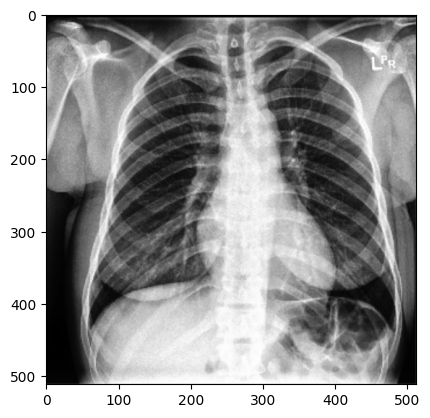

After MixUp: images.shape = torch.Size([8, 1, 512, 512]), converted_labels.shape = torch.Size([8, 8])


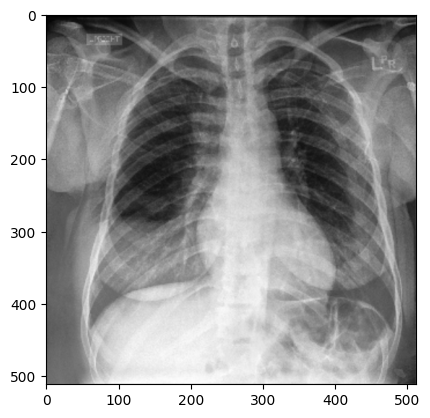

In [556]:
# MixUp implement as part of torchvision augmentations
for batch in dataloader:
    images = batch['img']
    labels = batch['lab']
    pos_idx = np.argwhere(labels == 1)
    pos_idx = pd.DataFrame(pos_idx).T
    pos_idx = pos_idx.groupby(0).apply(lambda x: x.sample(1, random_state=0)).reset_index(drop=True)
    converted_labels = pd.DataFrame(index=range(8), columns = ["lab"])
    converted_labels.loc[pos_idx[0], "lab"] = pos_idx[1]
    # Fill in as No Finding 
    converted_labels = torch.from_numpy(converted_labels.fillna(7).values.squeeze()).to(torch.int64)
    
    print(f"Before MixUp: {images.shape = }, {converted_labels.shape = }")
    plt.imshow(torchxrayvision_numpy_to_pil(np.array(images[0, :])), cmap='gray')
    plt.show()
    
    
    images, converted_labels = mixup(images, converted_labels)
    print(f"After MixUp: {images.shape = }, {converted_labels.shape = }")
    
    plt.imshow(torchxrayvision_numpy_to_pil(np.array(images[0, :])), cmap='gray')
    plt.show()
    
    break

# Visualize raw images from each dataset

In [30]:
img_dirs = {"mimic": "/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files", 
                    "padchest": "/data/healthy-ml/gobi1/data/PadChest/images-224", 
                    "chexpert": "/data/healthy-ml/gobi1/data", 
                    "nih": "/data/healthy-ml/gobi1/data/ChestXray8/images"}

In [31]:
with open("cxr_prompt_files_base10000.pkl", "rb") as f: 
    metadata = pickle.load(f)

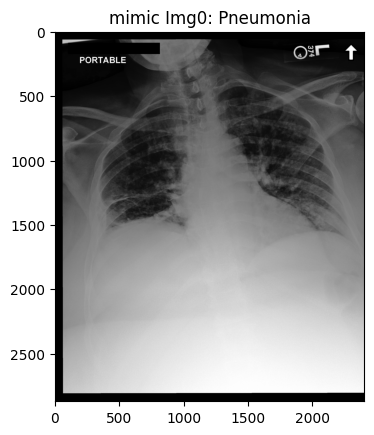

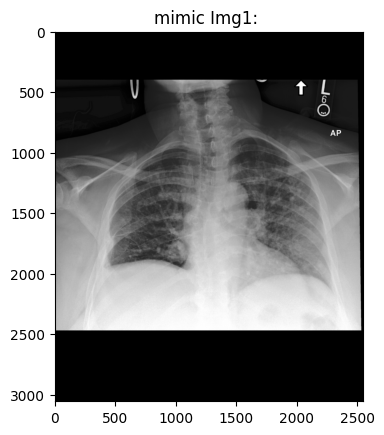

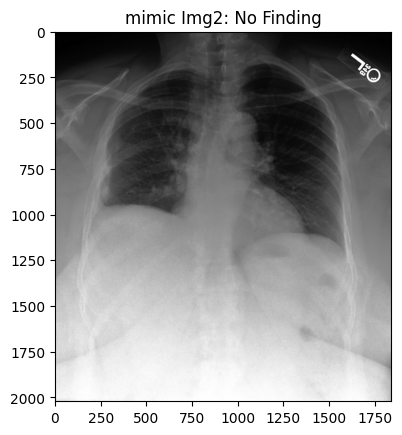

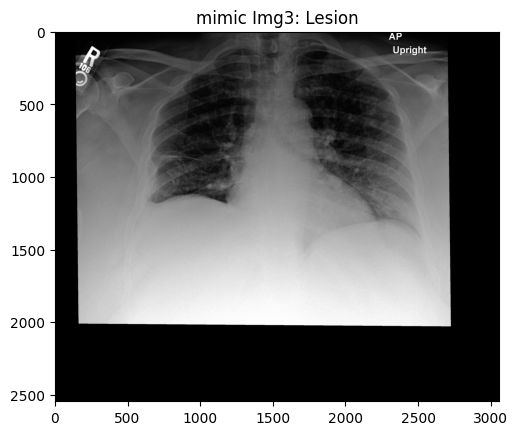

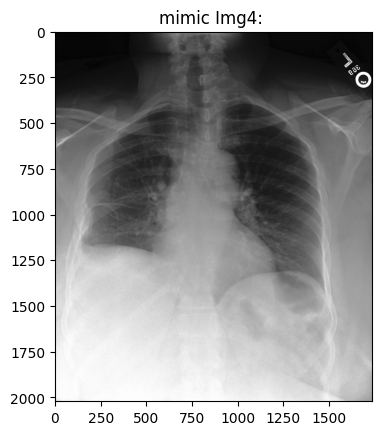

In [46]:
target = "mimic" 
offset = 0

for i in range(offset, offset + 5): 
    labels = metadata[target]["test"]['labels'].iloc[i]
    img = cv2.imread(img_dirs[target] + "/" + metadata[target]["test"]['file_suffix'].iloc[i])
    plt.title(f"{target} Img{i}: {labels}")
    plt.imshow(img)
    plt.show()

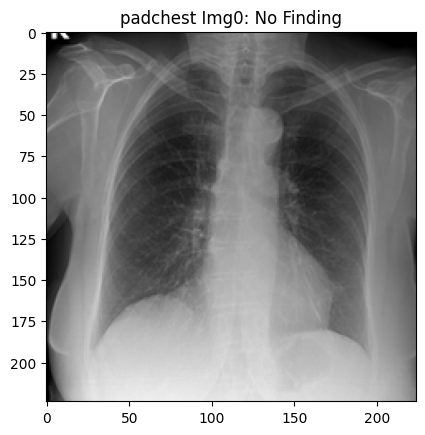

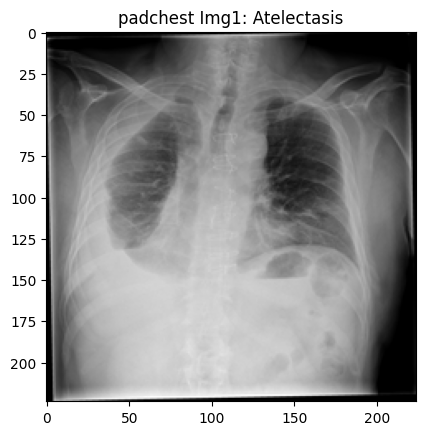

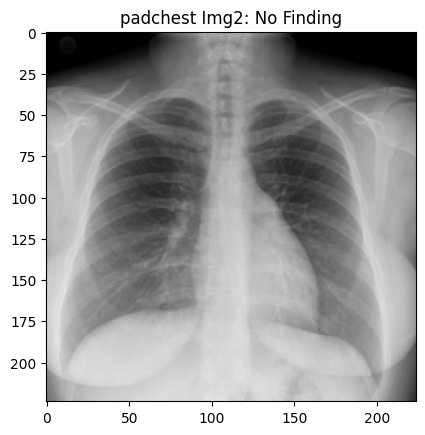

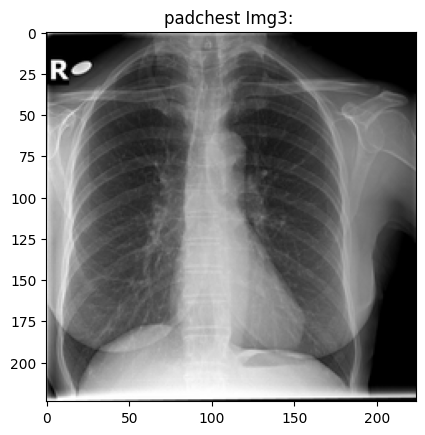

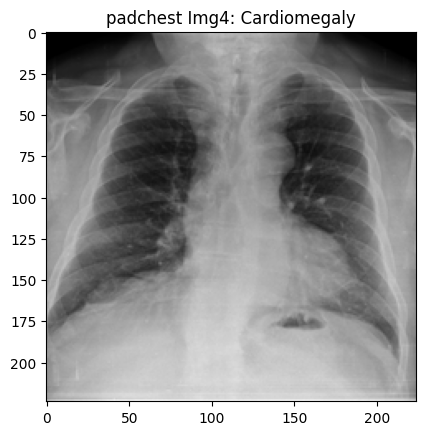

In [42]:
target = "padchest" 
offset = 0

for i in range(offset, offset + 5): 
    labels = metadata[target]["test"]['labels'].iloc[i]
    img = cv2.imread(img_dirs[target] + "/" + metadata[target]["test"]['file_suffix'].iloc[i])
    plt.title(f"{target} Img{i}: {labels}")
    plt.imshow(img)
    plt.show()

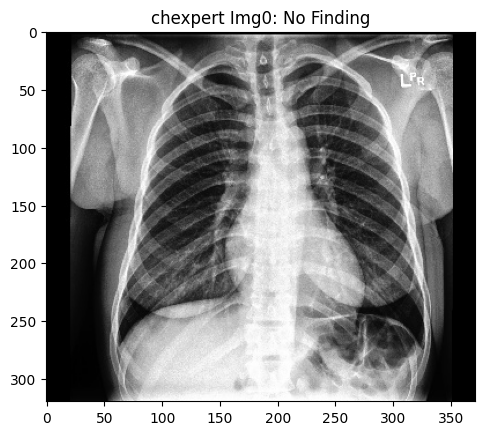

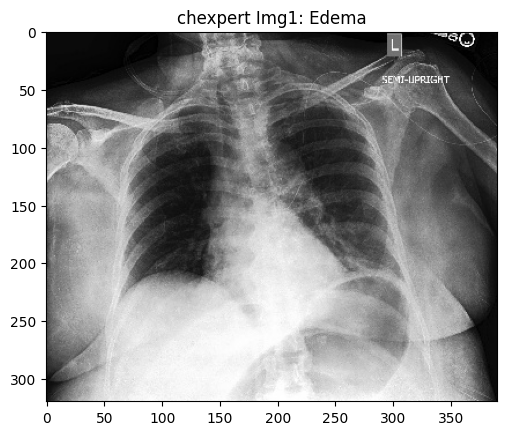

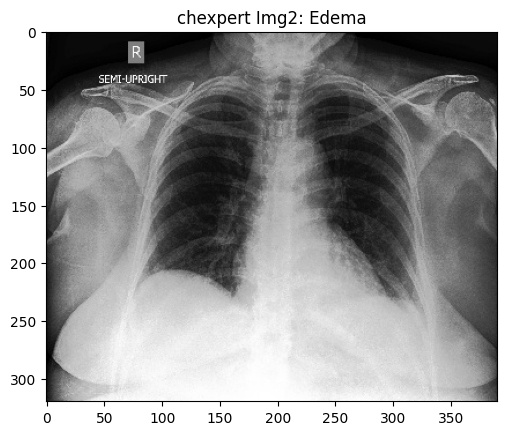

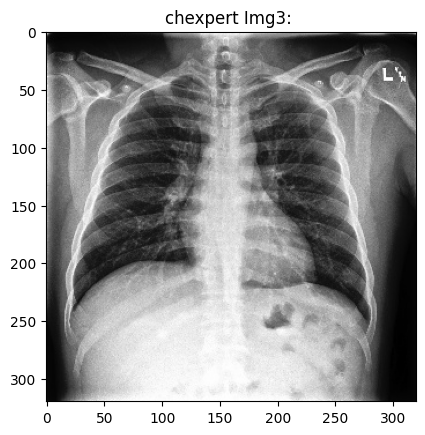

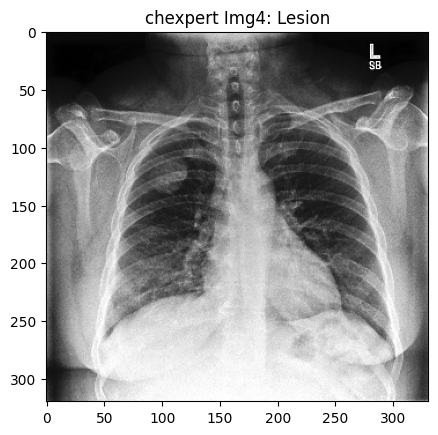

In [44]:
target = "chexpert" 
offset = 0

for i in range(offset, offset + 5): 
    labels = metadata[target]["test"]['labels'].iloc[i]
    img = cv2.imread(img_dirs[target] + "/" + metadata[target]["test"]['file_suffix'].iloc[i])
    plt.title(f"{target} Img{i}: {labels}")
    plt.imshow(img)
    plt.show()

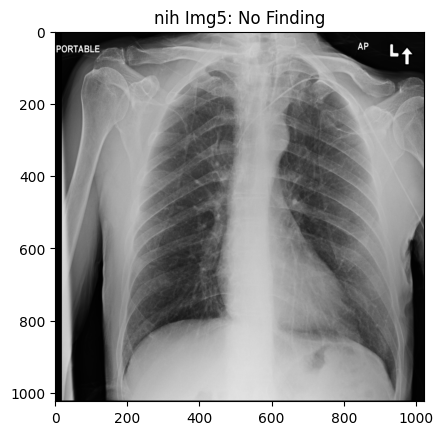

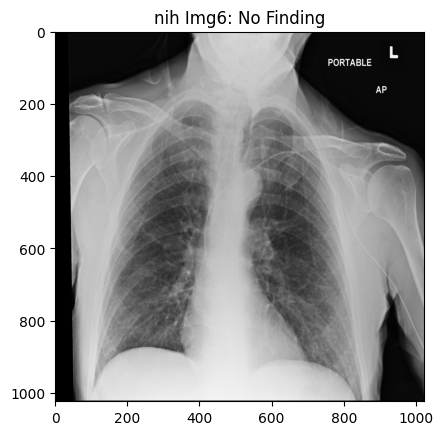

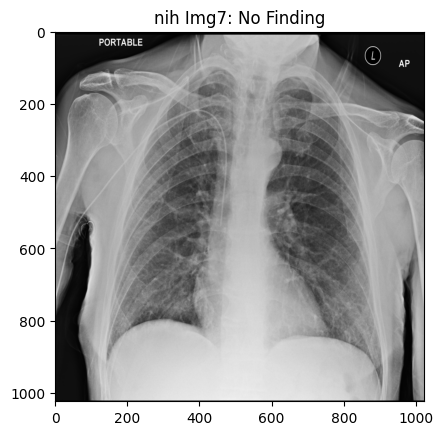

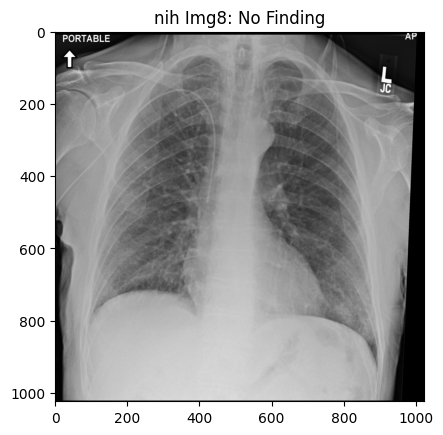

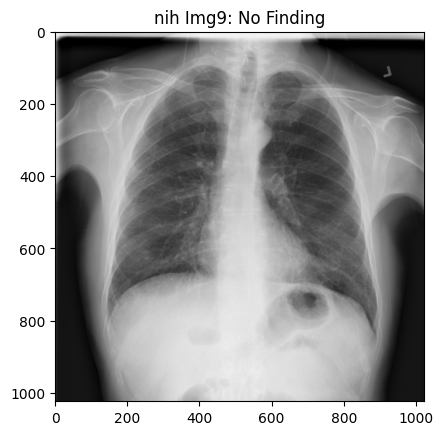

In [47]:
target = "nih" 
offset = 5

for i in range(offset, offset + 5): 
    labels = metadata[target]["test"]['labels'].iloc[i]
    img = cv2.imread(img_dirs[target] + "/" + metadata[target]["test"]['file_suffix'].iloc[i])
    plt.title(f"{target} Img{i}: {labels}")
    plt.imshow(img)
    plt.show()

# Finetune torchxrayvision classifier

## CutMix and Mixup

In [693]:
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score
from tqdm import tqdm

In [941]:
def mask_from_file(example, xresolution, yresolution): 
    height = example["Height"]
    width = example["Width"]
    rightLungMask_RLE = example["Right Lung"]
    leftLungMask_RLE = example["Left Lung"]
    heartMask_RLE = example["Heart"]

    rightLungMask = get_mask_from_RLE(rightLungMask_RLE, height, width)
    leftLungMask = get_mask_from_RLE(leftLungMask_RLE, height, width)
    heartMask = get_mask_from_RLE(heartMask_RLE, height, width)

    rightLungMask_resized = cv2.resize(rightLungMask, (xresolution, yresolution), interpolation =cv2.INTER_NEAREST)
    leftLungMask_resized = cv2.resize(leftLungMask, (xresolution, yresolution), interpolation =cv2.INTER_NEAREST)
    heartMask_resized = cv2.resize(heartMask, (xresolution, yresolution), interpolation =cv2.INTER_NEAREST)
    combined_mask = rightLungMask_resized | leftLungMask_resized | heartMask_resized
    return combined_mask

In [581]:
def convert_output(model_name, outputs): 
    # Function that convert the model output to standard 8 labels 
    output_mapping = {
        "mimic": [0, 10, 1, 4, 14, 8, 3], 
        "chexpert": [0, 10, 1, 4, 14, 8, 3], 
        "padchest": [0, 10, 1, 4, 8, 3], 
        "nih": [0, 10, 1, 4, 8, 3], 
        "all": [0, 10, 1, 4, 14, 8, 3],
    }
    new_outputs = outputs[:, output_mapping[model_name]]

    if model_name == "padchest" or model_name == "nih": 
        lesion = torch.max(outputs[:, 11], outputs[:, 12])
        new_outputs = torch.hstack((new_outputs[:, :4], lesion.unsqueeze(1), new_outputs[:, 4:]))

    # Append "No Findings" output as last column 
    no_finding_output = outputs[:, [i for i, x in enumerate(model.pathologies) if x != '']]
    # Max probability over all class with positive finding, then take the inverse 
    no_finding = 1. - no_finding_output.max(axis=1)[0]
    new_outputs = torch.hstack((new_outputs, no_finding.unsqueeze(1)))
    return new_outputs

In [1156]:
# Specific to CXR labelled in order of pathologies 
def convert_target_cxr(labels): 
    pos_idx = np.argwhere(labels == 1)
    pos_idx = pd.DataFrame(pos_idx)
    assert(pos_idx.shape[1] == 2)
    pos_idx = pos_idx.groupby(0).apply(lambda x: x.sample(1, random_state=0)).reset_index(drop=True)
    converted_labels = pd.DataFrame(index=range(labels.shape[0]), columns = ["label"])
    converted_labels.loc[pos_idx[0], "label"] = pos_idx[1].values
    # Fill in as No Finding 
    converted_labels = torch.from_numpy(converted_labels.fillna(7).values.squeeze()).to(torch.int64)
    return converted_labels

In [1132]:
def valid_test_epoch(name, epoch, model, model_name, device, data_loader, 
                     criterion, num_classes=8, limit=None, 
                     use_cutmix=False, use_mixup=False, 
                     resolution=512):
    model.to(device)
    model.eval()
    
    if use_cutmix: 
        cutmix = v2.CutMix(num_classes=num_classes)
    if use_mixup: 
        mixup = v2.MixUp(num_classes=num_classes) 

    avg_loss = []
    task_outputs={}
    task_targets={}
    for task in range(data_loader.dataset[0]["lab"].shape[0]):
        task_outputs[task] = []
        task_targets[task] = []
    
    with torch.no_grad():
        t = tqdm(data_loader)
        for batch_idx, samples in enumerate(t):
            if limit and (batch_idx > limit):
                print("breaking out")
                break
            
            indices = samples["idx"]
            images = samples["img"]
            targets = samples["lab"]
            
            if use_cutmix: 
                converted_targets = convert_target_cxr(targets.numpy())
                images, converted_targets = cutmix(images, converted_targets)
            if use_mixup: 
                converted_targets = convert_target_cxr(targets.numpy())
                images, converted_targets = mixup(images, converted_targets)           

            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            outputs = convert_output(model_name, outputs)
            
            loss = torch.zeros(1).to(device).double()
            for task in range(targets.shape[1]):
                task_output = outputs[:,task]
                task_target = targets[:,task]

                mask = ~torch.isnan(task_target)
                task_output = task_output[mask]
                task_target = task_target[mask]
                if len(task_target) > 0:
                    loss += criterion(task_output.double(), task_target.double())
                
                task_outputs[task].append(task_output.detach().cpu().numpy())
                task_targets[task].append(task_target.detach().cpu().numpy())

            loss = loss.sum()
            
            avg_loss.append(loss.detach().cpu().numpy())
            t.set_description(f'Epoch {epoch + 1} - {name} - Loss = {np.mean(avg_loss):4.4f}')
            
        for task in range(len(task_targets)):
            task_outputs[task] = np.concatenate(task_outputs[task])
            task_targets[task] = np.concatenate(task_targets[task])
    
        task_aucs = []
        for task in range(len(task_targets)):
            if len(np.unique(task_targets[task]))> 1:
                task_auc = roc_auc_score(task_targets[task], task_outputs[task])
                task_aucs.append(task_auc)
            else:
                task_aucs.append(np.nan)

    task_aucs = np.asarray(task_aucs)
    auc = np.mean(task_aucs[~np.isnan(task_aucs)])
    print(f'Epoch {epoch + 1} - {name} - Avg AUC = {auc:4.4f}')
    return auc, task_aucs, task_outputs, task_targets

In [1167]:
def train_epoch(name, epoch, model, model_name, device, data_loader, 
                     criterion, optimizer, num_classes=8,
                     use_cutmix=False, use_mixup=False, 
                     resolution=512, freeze_encoder=True, limit=None):
    model.to(device)
    model.train()
    
    if freeze_encoder: 
        for param in model.parameters():
            param.requires_grad = False
        # Only train classifier 
        for param in model.classifier.parameters():
            param.requires_grad = True
    
    if use_cutmix: 
        cutmix = v2.CutMix(num_classes=num_classes)
    if use_mixup: 
        mixup = v2.MixUp(num_classes=num_classes) 

    avg_loss = []
    task_outputs={}
    task_targets={}
    for task in range(data_loader.dataset[0]["lab"].shape[0]):
        task_outputs[task] = []
        task_targets[task] = []
         
    t = tqdm(data_loader)
    for batch_idx, samples in enumerate(t):
        if limit and (batch_idx > limit):
                print("breaking out")
                break
                
        optimizer.zero_grad()
        indices = samples["idx"]
        images = samples["img"]
        targets = samples["lab"]

        if use_cutmix: 
            converted_targets = convert_target_cxr(targets.numpy())
            images, converted_targets = cutmix(images, converted_targets)
        if use_mixup: 
            converted_targets = convert_target_cxr(targets.numpy())
            images, converted_targets = mixup(images, converted_targets)           

        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        outputs = convert_output(model_name, outputs)

        loss = torch.zeros(1).to(device).double()
        for task in range(targets.shape[1]):
            task_output = outputs[:,task]
            task_target = targets[:,task]

            mask = ~torch.isnan(task_target)
            task_output = task_output[mask]
            task_target = task_target[mask]
            if len(task_target) > 0:
                loss += criterion(task_output.double(), task_target.double())

            task_outputs[task].append(task_output.detach().cpu().numpy())
            task_targets[task].append(task_target.detach().cpu().numpy())

        loss = loss.sum()
        
        # Backprop
        loss.backward()
        optimizer.step()

        avg_loss.append(loss.detach().cpu().numpy())
        t.set_description(f'Epoch {epoch + 1} - {name} - Loss = {np.mean(avg_loss):4.4f}')

    for task in range(len(task_targets)):
        task_outputs[task] = np.concatenate(task_outputs[task])
        task_targets[task] = np.concatenate(task_targets[task])

    task_aucs = []
    for task in range(len(task_targets)):
        if len(np.unique(task_targets[task]))> 1:
            task_auc = roc_auc_score(task_targets[task], task_outputs[task])
            task_aucs.append(task_auc)
        else:
            task_aucs.append(np.nan)

    task_aucs = np.asarray(task_aucs)
    auc = np.mean(task_aucs[~np.isnan(task_aucs)])
    print(f'Epoch {epoch + 1} - {name} - Avg AUC = {auc:4.4f}')
    
    return model, auc, task_aucs, task_outputs, task_targets

In [865]:
model_name = "mimic"
model = xrv.models.DenseNet(weights="densenet121-res224-mimic_ch")

In [1150]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [1162]:
data_loader = torch.utils.data.DataLoader(split_datasets["mimic"]["train"], batch_size=4, shuffle=False)

In [1168]:
# Training 
model_train, auc, task_aucs, task_outputs, task_targets = train_epoch("train", 0, model, model_name, 
                                                              "cuda", data_loader, 
                                                              criterion, optimizer, 
                                                              num_classes=8, use_mixup=True, 
                                                              freeze_encoder=True, 
                                                              limit=10, # Set limit of num of steps for debugging
                                                                     )

Epoch 1 - train - Loss = 6.4315:   0%|                                                                     | 11/42628 [00:15<17:10:42,  1.45s/it]

breaking out
Epoch 1 - train - Avg AUC = 0.6390


In [ ]:
# Evaluation 
auc, task_aucs, task_outputs, task_targets = valid_test_epoch("test", 0, model, model_name, 
                                                              "cuda", data_loader, 
                                                              torch.nn.BCEWithLogitsLoss(), 
                                                              num_classes=8, use_mixup=True)

In [1134]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_se

In [1135]:
# Classification layer 
model.classifier

Linear(in_features=1024, out_features=18, bias=True)

In [1144]:
model.classifier.parameters()

<generator object Module.parameters at 0x7f8fb4ed9c10>

In [1140]:
# Feature extractor
model.features

Sequential(
  (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke

## Debug crop code (scrap)

In [ ]:
def find_crop_coord(mask, resolution): 
    threshold = 0.5
    xmin,ymin,xmax,ymax = (-1,-1,-1,-1)
    
    for j in range(resolution):
        for i in range(resolution):
            if mask[j,i] <= threshold: continue
            xmin = i if xmin == -1 or xmin > i else xmin
            xmax = i if xmax == -1 or xmax < i else xmax
            ymin = j if ymin == -1 or ymin > j else ymin
            ymax = j if ymax == -1 or ymax < j else ymax
    return xmin,ymin,xmax,ymax

In [ ]:
class SquarePad:
    def __call__(self, image):
        s = image.size()
        max_wh = np.max([s[-1], s[-2]])
        hp = int((max_wh - s[-1]) / 2)
        vp = int((max_wh - s[-2]) / 2)
        padding = (hp, vp, hp, vp)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')

In [ ]:
squarepad = SquarePad()

In [1063]:
# Adapted from torchxrayvision train_utils
# def valid_test_epoch(name, epoch, model, model_name, device, data_loader, 
#                      criterion, num_classes=8, limit=None, 
#                      use_cutmix=False, use_mixup=False, 
#                      use_crop=False, mask_file=None, identifier_file=None, mask_concept=None, 
#                      resolution=512):
#     model.to(device)
#     model.eval()
    
#     if use_cutmix: 
#         cutmix = v2.CutMix(num_classes=num_classes)
#     if use_mixup: 
#         mixup = v2.MixUp(num_classes=num_classes) 

#     avg_loss = []
#     task_outputs={}
#     task_targets={}
#     for task in range(data_loader.dataset[0]["lab"].shape[0]):
#         task_outputs[task] = []
#         task_targets[task] = []
    
#     with torch.no_grad():
#         t = tqdm(data_loader)
#         for batch_idx, samples in enumerate(t):
#             if limit and (batch_idx > limit):
#                 print("breaking out")
#                 break
            
#             indices = samples["idx"]
#             images = samples["img"]
#             targets = samples["lab"]
            
#             if use_cutmix: 
#                 converted_targets = convert_target_cxr(targets.numpy())
#                 images, converted_targets = cutmix(images, converted_targets)
#             if use_mixup: 
#                 converted_targets = convert_target_cxr(targets.numpy())
#                 images, converted_targets = mixup(images, converted_targets)
            
#             if use_crop: 
#                 mask_subset = mask_file[mask_file[mask_concept].isin(identifier_file.iloc[indices])]
#                 for i in range(len(mask_subset)): 
#                     m = mask_from_file(mask_subset.iloc[i], resolution, resolution)
#                     m = transform(np.expand_dims(m, axis=0))
                    
#                     plt.figure()
#                     plt.imshow(torchxrayvision_numpy_to_pil(m))
#                     m = m.squeeze()
#                     xmin,ymin,xmax,ymax = find_crop_coord(m, resolution)
#                     plt.figure()
#                     plt.imshow(torchxrayvision_numpy_to_pil(images[0].numpy()))
#                     print("{} {} {} {}".format(xmin,ymin,xmax,ymax))
#                     image_post = torchvision.transforms.functional.crop(images[i],top=ymin, left=xmin, 
#                                               height=ymax-ymin, width=xmax-xmin)
#                     # Pad to square
#                     image_post = squarepad(image_post)
#                     plt.figure()
#                     plt.imshow(torchxrayvision_numpy_to_pil(image_post.numpy()))
#                     image_post = torchvision.transforms.functional.resize(image_post, size=resolution)
#                     plt.figure()
#                     plt.imshow(torchxrayvision_numpy_to_pil(image_post.numpy()))
#                     # image_post = torchvision.transforms.functional.center_crop(image_post, output_size=resolution)
#                     image_post = squarepad(image_post)
#                     plt.figure()
#                     plt.imshow(torchxrayvision_numpy_to_pil(image_post.numpy()))
#                     if i == 0: 
#                         images_cropped = image_post
#                     else: 
#                         images_cropped = torch.cat((images_cropped, image_post))
#                     break
#                 # images = images_cropped
# #             plt.figure()
# #             plt.imshow(torchxrayvision_numpy_to_pil(images[0].numpy()))
# #             plt.figure()
# #             plt.imshow(torchxrayvision_numpy_to_pil(masks[0]))
# #             plt.figure()
# #             plt.imshow(torchxrayvision_numpy_to_pil(images_cropped[0].numpy()))
#             return

#             images = images.to(device)
#             targets = targets.to(device)

#             outputs = model(images)
#             outputs = convert_output(model_name, outputs)
            
#             loss = torch.zeros(1).to(device).double()
#             for task in range(targets.shape[1]):
#                 task_output = outputs[:,task]
#                 task_target = targets[:,task]

#                 mask = ~torch.isnan(task_target)
#                 task_output = task_output[mask]
#                 task_target = task_target[mask]
#                 if len(task_target) > 0:
#                     loss += criterion(task_output.double(), task_target.double())
                
#                 task_outputs[task].append(task_output.detach().cpu().numpy())
#                 task_targets[task].append(task_target.detach().cpu().numpy())

#             loss = loss.sum()
            
#             avg_loss.append(loss.detach().cpu().numpy())
#             t.set_description(f'Epoch {epoch + 1} - {name} - Loss = {np.mean(avg_loss):4.4f}')
            
#         for task in range(len(task_targets)):
#             task_outputs[task] = np.concatenate(task_outputs[task])
#             task_targets[task] = np.concatenate(task_targets[task])
    
#         task_aucs = []
#         for task in range(len(task_targets)):
#             if len(np.unique(task_targets[task]))> 1:
#                 task_auc = roc_auc_score(task_targets[task], task_outputs[task])
#                 task_aucs.append(task_auc)
#             else:
#                 task_aucs.append(np.nan)

#     task_aucs = np.asarray(task_aucs)
#     auc = np.mean(task_aucs[~np.isnan(task_aucs)])
#     print(f'Epoch {epoch + 1} - {name} - Avg AUC = {auc:4.4f}')
#     return auc, task_aucs, task_outputs, task_targets

  0%|                                                                                                                  | 0/12114 [00:01<?, ?it/s]

76 138 465 407


TypeError: cannot unpack non-iterable NoneType object

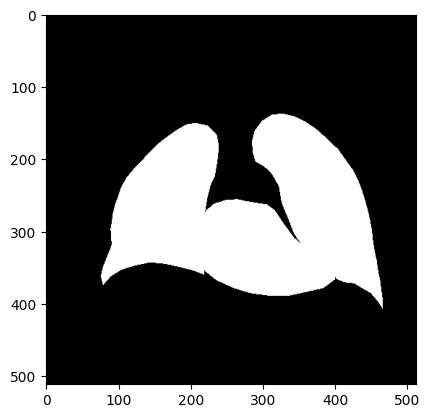

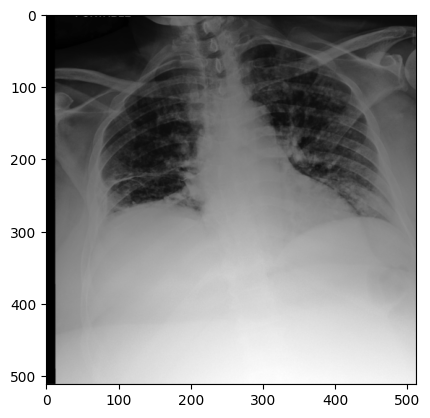

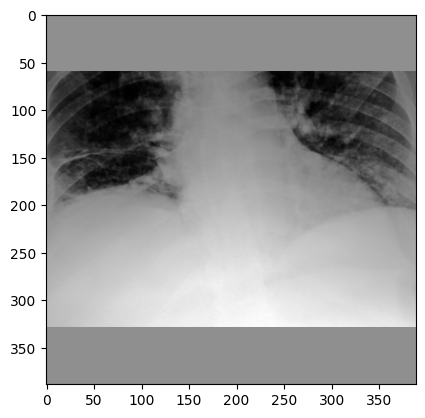

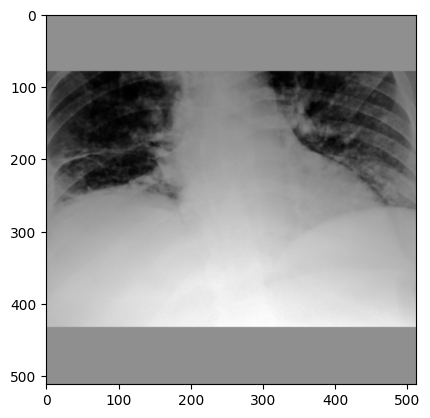

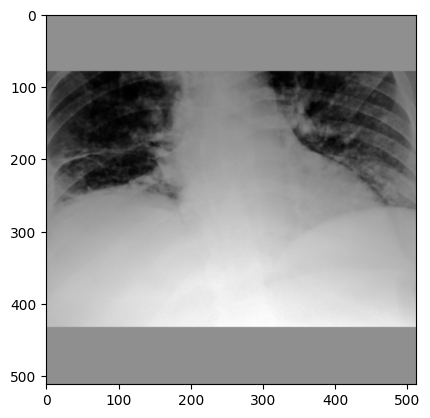

In [1064]:
auc, task_aucs, task_outputs, task_targets = valid_test_epoch("test", 0, model, model_name, 
                                                              "cuda", data_loader, 
                                                              torch.nn.BCEWithLogitsLoss(), 
                                                              num_classes=8, use_crop=True,
                                                              identifier_file = original_datasets["mimic"].csv['dicom_id'], 
                                                              mask_file=df_mask, 
                                                              mask_concept="dicom_id", 
                                                             resolution=512)

In [993]:
img.shape

(512, 512)

In [1130]:
m = mask_from_file(mask_subset.iloc[0], 1024, 1024)

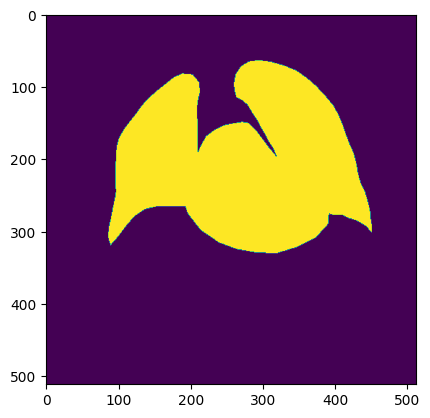

In [1012]:
plt.imshow(m)

In [1017]:
find_crop_coord(m, 512)

(86, 64, 450, 330)

In [1026]:
m.shape

(512, 512)

In [1027]:
img.shape

(512, 512)

In [1028]:
result = cv2.bitwise_and(img, img, mask=m)

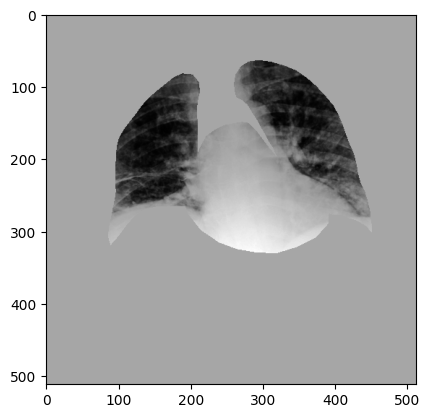

In [1031]:
plt.imshow(result, cmap='gray')

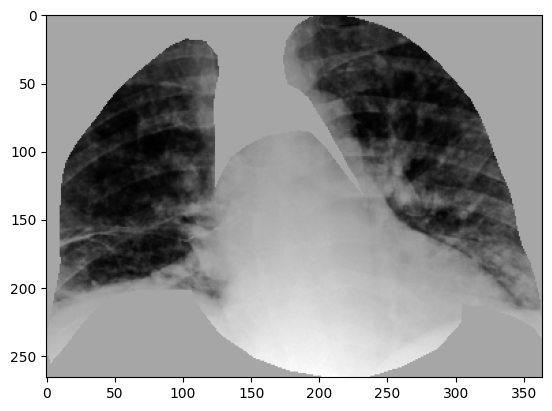

In [1066]:
plt.imshow(crop_result, cmap='gray')

In [1075]:
scaled = np.repeat(img[:, :, np.newaxis], 3, axis=2)
# Normalize image to between 0 and 255
scaled = (255*(scaled - np.min(scaled))/np.ptp(scaled)).astype(int) 

In [1116]:
# color to fill
green = np.array([0,255,0], dtype='uint8') 

# equal color where mask, else image
# this would paint your object silhouette entirely with `color`
masked_img = np.where(mask_mod[...,None], green, scaled)

out = cv2.addWeighted(scaled, 0.8, masked_img, 0.2,0)

In [1111]:
m

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [1082]:
np.expand_dims(m, axis=2).shape

(512, 512, 1)

In [1089]:
transform_equivalent = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(512),
                                            torchvision.transforms.Resize(512),])

In [1113]:
mask_mod = m * 255

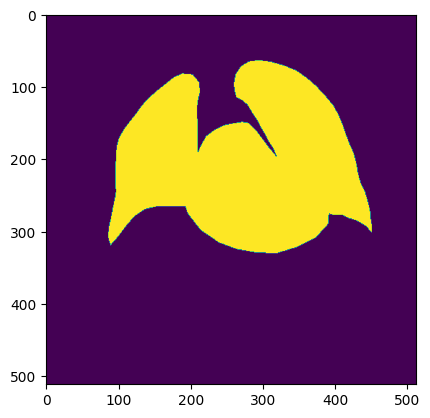

In [1114]:
plt.imshow(mask_mod)

In [1124]:
def crop_center(img):
    y, x = img.shape
    crop_size = np.min([y, x])
    startx = x // 2 - (crop_size // 2)
    starty = y // 2 - (crop_size // 2)
    return img[starty:starty + crop_size, startx:startx + crop_size]

In [1126]:
m_out = crop_center(m)

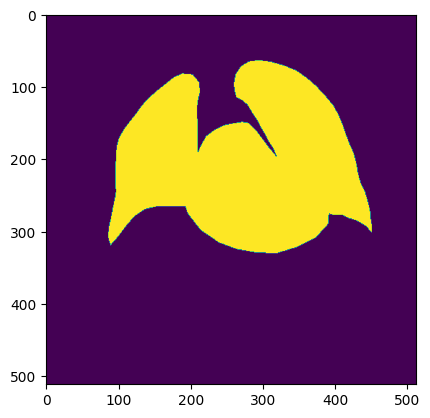

In [1127]:
plt.imshow(m_out)

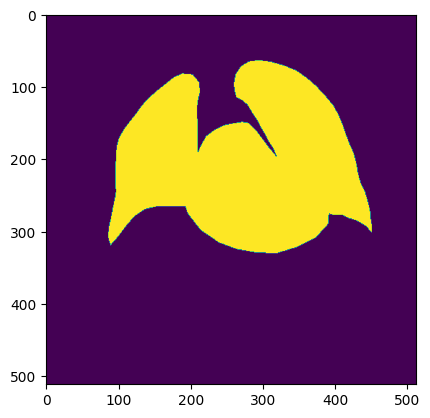

In [1115]:
mask_mod = transform(np.expand_dims(mask_mod, axis=0)).squeeze()
plt.imshow(mask_mod)

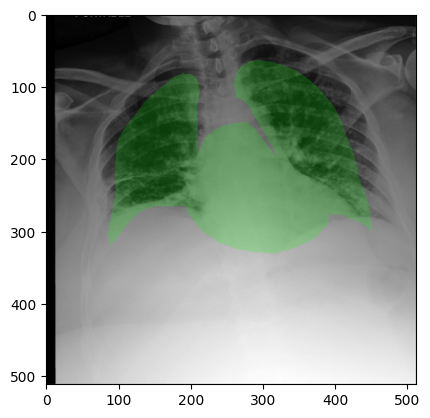

In [1117]:
# There's a misalignment between mask and image 
plt.imshow(out)

In [1065]:
crop_result = torchvision.transforms.functional.crop(torch.Tensor(result), 
                                                 top=ymin, left=xmin, 
                                              height=ymax-ymin, width=xmax-xmin)

In [1018]:
xmin,ymin,xmax,ymax = 86, 64, 450, 330
crop_img = torchvision.transforms.functional.crop(torch.Tensor(img), 
                                                 top=ymin, left=xmin, 
                                              height=ymax-ymin, width=xmax-xmin)

In [1021]:
crop_mask = torchvision.transforms.functional.crop(torch.Tensor(m), 
                                                 top=ymin, left=xmin, 
                                              height=ymax-ymin, width=xmax-xmin)

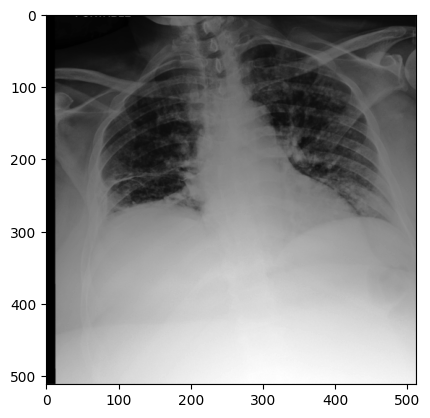

In [1019]:
plt.imshow(img, cmap='gray')

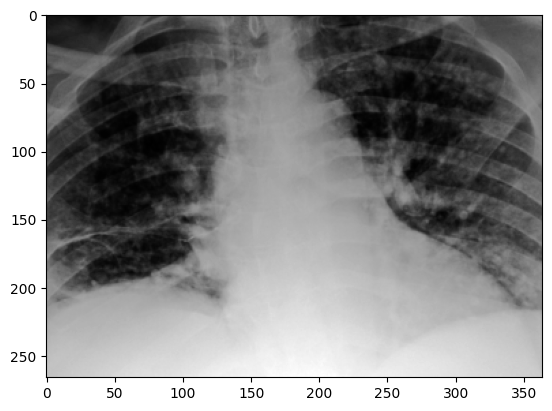

In [1020]:
plt.imshow(crop_img, cmap='gray')

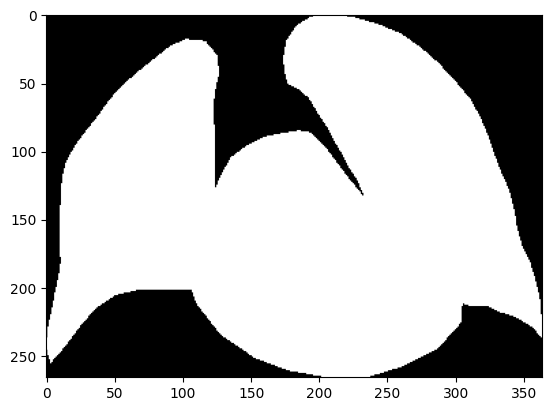

In [1022]:
plt.imshow(crop_mask, cmap='gray')

In [ ]:
torchvision.transforms.functional.crop(images[i], top=xmin, left=ymin, 
                                              height=xmax-xmin, width=ymax-ymin)

In [966]:
split_datasets["mimic"]["test"][0]['img'].shape

(1, 2870, 2402)

In [870]:
split_datasets["mimic"]["test"].csv.iloc[:4][['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Lung Lesion',
 'Pneumonia',
 'Pneumothorax',
 'No Finding']]

Atelectasis  Cardiomegaly  Consolidation  Edema  Lung Lesion  Pneumonia  \
0          NaN           NaN            NaN   -1.0          NaN        1.0   
1          NaN           NaN            NaN    NaN          NaN       -1.0   
2          0.0           0.0            0.0    0.0          0.0        0.0   
3          NaN           NaN            NaN    NaN          1.0        NaN   

   Pneumothorax  No Finding  
0           NaN         NaN  
1           NaN         NaN  
2           0.0         1.0  
3           NaN         NaN

In [913]:
split_datasets["mimic"]["test"][0]

{'idx': 8,
 'lab': array([nan, nan, nan, nan, nan,  1., nan,  0.]),
 'img': array([[[ -765.8072 ,  -885.1364 ,  -885.5431 , ...,  -810.5901 ,
           -814.1326 ,  -705.70667],
         [ -885.1365 , -1023.0598 , -1023.5298 , ...,  -934.9212 ,
           -936.02386,  -814.74695],
         [ -885.5431 , -1023.5298 , -1024.     , ...,  -935.382  ,
           -933.27936,  -810.87994],
         ...,
         [ -885.5431 , -1023.5298 , -1024.     , ...,   867.6988 ,
            865.1551 ,   748.6316 ],
         [ -885.1365 , -1023.0598 , -1023.5298 , ...,   878.6344 ,
            873.74316,   757.00824],
         [ -765.8072 ,  -885.1364 ,  -885.5431 , ...,   765.6216 ,
            761.55005,   656.8363 ]]], dtype=float32)}

In [1006]:
split_datasets["mimic"]["test"].csv.iloc[0]['dicom_id']

'd0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738'

In [1008]:
mask_subset = df_mask[df_mask['dicom_id'] == 'd0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738']

In [935]:
original_datasets["mimic"][8]

{'idx': 8,
 'lab': array([nan, nan, nan, nan, nan,  1., nan,  0.]),
 'img': array([[[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
         ...,
         [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024., ..., -1024., -1024., -1024.]]],
       dtype=float32)}

In [932]:
split_datasets["mimic"]["test"].labels[0]

array([nan, nan, nan, nan, nan,  1., nan,  0.])

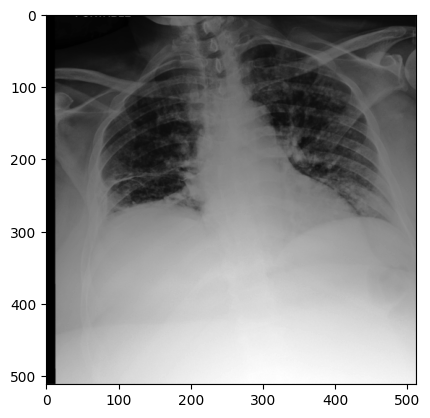

In [989]:
plt.imshow(split_datasets["mimic"]["test"][0]['img'].squeeze(), cmap='gray')

In [990]:
img = split_datasets["mimic"]["test"][0]['img'].squeeze()

In [934]:
original_datasets["mimic"][0]

{'idx': 0,
 'lab': array([0., 0., 0., 0., 0., 0., 0., 1.]),
 'img': array([[[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
         ...,
         [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024., ..., -1024., -1024., -1024.]]],
       dtype=float32)}

In [920]:
original_datasets["mimic"].labels[0]

array([0., 0., 0., 0., 0., 0., 0., 1.])

In [922]:
split_datasets["mimic"]["test"].csv.iloc[0]

subject_id                                                                        10000935
study_id                                                                          50578979
Atelectasis                                                                            NaN
Cardiomegaly                                                                           NaN
Consolidation                                                                          NaN
Edema                                                                                 -1.0
Enlarged Cardiomediastinum                                                             NaN
Fracture                                                                               NaN
Lung Lesion                                                                            NaN
Lung Opacity                                                                          -1.0
No Finding                                                                             NaN

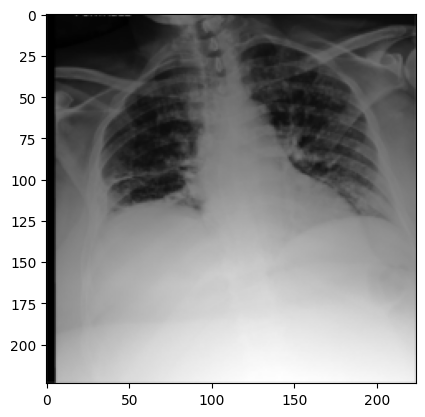

In [914]:
plt.imshow(torchxrayvision_numpy_to_pil(split_datasets["mimic"]["test"][0]['img']))

In [899]:
split_datasets["mimic"]["test"].labels[:4]

array([[nan, nan, nan, nan, nan,  1., nan,  0.],
       [nan, nan, nan, nan, nan, nan, nan,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [nan, nan, nan, nan,  1., nan, nan,  0.]])

In [ ]:
split_datasets["mimic"]["test"].labels[:4]

In [893]:
sample["lab"]

tensor([[nan, nan, nan, nan, nan, 1., nan, 0.],
        [nan, nan, nan, nan, nan, nan, nan, 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [nan, nan, nan, nan, 1., nan, nan, 0.]], dtype=torch.float64)

In [896]:
split_ids["mimic"]["test"][:4]

array([ 8,  9, 10, 11])

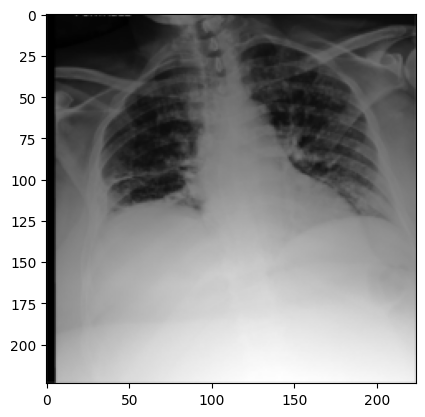

In [906]:
plt.imshow(torchxrayvision_numpy_to_pil(sample['img'][0].numpy()))

In [923]:
img1 = Image.open("/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files/p10/p10000935/s50578979/d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738.jpg")
# img1 = Image.open("/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files/p10/p10002557/s50547046/e45d57af-62690e1a-9bdf2d66-d10e02de-e9794fc4.jpg")

In [898]:
original_datasets["mimic"].csv.iloc[split_ids["mimic"]["test"][:4]][['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Lung Lesion',
 'Pneumonia',
 'Pneumothorax',
 'No Finding']]

Atelectasis  Cardiomegaly  Consolidation  Edema  Lung Lesion  Pneumonia  \
15          NaN           NaN            NaN   -1.0          NaN        1.0   
17          NaN           NaN            NaN    NaN          NaN       -1.0   
19          0.0           0.0            0.0    0.0          0.0        0.0   
20          NaN           NaN            NaN    NaN          1.0        NaN   

    Pneumothorax  No Finding  
15           NaN         NaN  
17           NaN         NaN  
19           0.0         1.0  
20           NaN         NaN

In [861]:
original_datasets["mimic"].csv.iloc[sample['idx']][['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Lung Lesion',
 'Pneumonia',
 'Pneumothorax',
 'No Finding']]

Atelectasis  Cardiomegaly  Consolidation  Edema  Lung Lesion  Pneumonia  \
15          NaN           NaN            NaN   -1.0          NaN        1.0   
17          NaN           NaN            NaN    NaN          NaN       -1.0   
19          0.0           0.0            0.0    0.0          0.0        0.0   
20          NaN           NaN            NaN    NaN          1.0        NaN   

    Pneumothorax  No Finding  
15           NaN         NaN  
17           NaN         NaN  
19           0.0         1.0  
20           NaN         NaN

In [858]:
for sample in data_loader: 
    print(sample)
    break

{'idx': tensor([ 8,  9, 10, 11]), 'lab': tensor([[nan, nan, nan, nan, nan, 1., nan, 0.],
        [nan, nan, nan, nan, nan, nan, nan, 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [nan, nan, nan, nan, 1., nan, nan, 0.]], dtype=torch.float64), 'img': tensor([[[[ -765.8072,  -885.1364,  -885.5431,  ...,  -810.5901,
            -814.1326,  -705.7067],
          [ -885.1365, -1023.0598, -1023.5298,  ...,  -934.9212,
            -936.0239,  -814.7469],
          [ -885.5431, -1023.5298, -1024.0000,  ...,  -935.3820,
            -933.2794,  -810.8799],
          ...,
          [ -885.5431, -1023.5298, -1024.0000,  ...,   867.6988,
             865.1551,   748.6316],
          [ -885.1365, -1023.0598, -1023.5298,  ...,   878.6344,
             873.7432,   757.0082],
          [ -765.8072,  -885.1364,  -885.5431,  ...,   765.6216,
             761.5500,   656.8363]]],


        [[[ -763.2016,  -883.5898,  -884.0353,  ...,  -884.0353,
            -883.5898,  -763.2016],
          [ -883

In [846]:
split_datasets["mimic"]["test"].csv.iloc[[8]]['dicom_id']

8    e45d57af-62690e1a-9bdf2d66-d10e02de-e9794fc4
Name: dicom_id, dtype: object

In [847]:
mask_subset = df_mask[df_mask['dicom_id'].isin(split_datasets["mimic"]["test"].csv.iloc[[8]]['dicom_id'])]

In [848]:
mask_subset

dicom_id  Dice RCA (Mean)  \
201868  e45d57af-62690e1a-9bdf2d66-d10e02de-e9794fc4         0.821055   

        Dice RCA (Max)                                          Landmarks  \
201868        0.864137  375,192,345,194,314,210,282,234,255,263,236,29...   

                                                Left Lung  \
201868  202315 16 203323 36 204345 42 205367 47 206389...   

                                               Right Lung  \
201868  196977 9 197986 28 199002 40 200024 45 201046 ...   

                                                    Heart  Height  Width  
201868  447973 8 448987 24 450002 39 451020 51 452038 ...    1024   1024

In [849]:
masks = mask_from_file(mask_subset, 512)

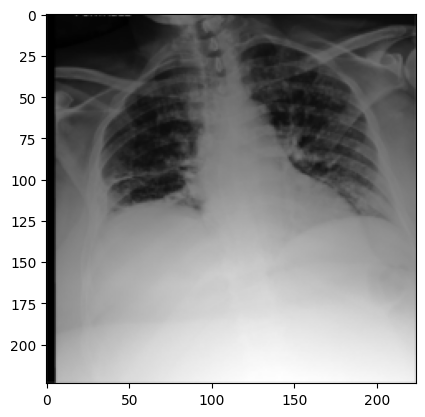

In [853]:
plt.imshow(torchxrayvision_numpy_to_pil(sample['img'][0].numpy()))

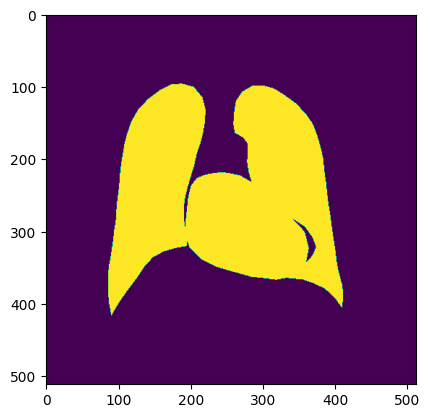

In [852]:
plt.imshow(masks[0])

In [771]:
original_datasets["mimic"].csv['dicom_id'].iloc[[242800, 132064,]] 

376285    32fb7803-7dc89bb6-30e5a4e0-09c09ff6-f84863ab
204435    c6131c93-82955be4-15fdf597-2c7d4828-8bd0104f
Name: dicom_id, dtype: object

In [775]:
mask_subset = df_mask[df_mask['dicom_id'].isin(original_datasets["mimic"].csv['dicom_id'].iloc[[242800, 132064,]])]

In [776]:
mask_subset

dicom_id  Dice RCA (Mean)  \
81560   32fb7803-7dc89bb6-30e5a4e0-09c09ff6-f84863ab         0.815148   
185557  c6131c93-82955be4-15fdf597-2c7d4828-8bd0104f         0.875992   

        Dice RCA (Max)                                          Landmarks  \
81560         0.908513  331,147,299,153,266,168,235,186,211,205,195,22...   
185557        0.897412  363,142,320,146,277,166,236,194,198,230,172,26...   

                                                Left Lung  \
81560   154179 37 155201 43 156223 49 157245 54 158267...   
185557  157312 13 158314 40 159327 55 160349 62 161371...   

                                               Right Lung  \
81560   150858 6 151877 17 152895 29 153914 41 154933 ...   
185557  145767 7 146780 22 147794 35 148807 50 149824 ...   

                                                    Heart  Height  Width  
81560   419264 20 420280 52 421297 77 422313 100 42333...    1024   1024  
185557  481773 19 482794 45 483815 59 484836 73 485857...    1024   1024

In [768]:
original_datasets["mimic"].csv['dicom_id']

0         02aa804e-bde0afdd-112c0b34-7bc16630-4e384014
2         2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab
4         68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714
5         fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818
6         ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c
                              ...                     
377089    3fcd0406-9b111603-feae7033-96632b3a-111333e5
377090    428e2c18-5721d8f3-35a05001-36f3d080-9053b83c
377092    58766883-376a15ce-3b323a28-6af950a0-16b793bd
377093    7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08
377094    1a1fe7e3-cbac5d93-b339aeda-86bb86b5-4f31e82e
Name: dicom_id, Length: 243324, dtype: object

In [ ]:
original_datasets["mimic"].csv[['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Lung Lesion',
 'Pneumonia',
 'Pneumothorax',
 'No Finding']].iloc[196865]

  0%|                                                                                   | 0/6057 [00:02<?, ?it/s]

tensor([242800, 132064,   9114, 236204, 115545,  18764,  49545, 113952])
0
tensor([[1., 1., nan, nan, nan, nan, nan, 0.],
        [0., nan, nan, nan, nan, 1., nan, 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [nan, 1., nan, 1., nan, 0., nan, 0.],
        [nan, 1., nan, nan, nan, nan, nan, 0.],
        [1., nan, nan, 0., nan, nan, 0., 0.],
        [nan, nan, nan, 1., nan, nan, 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
512


TypeError: cannot unpack non-iterable NoneType object

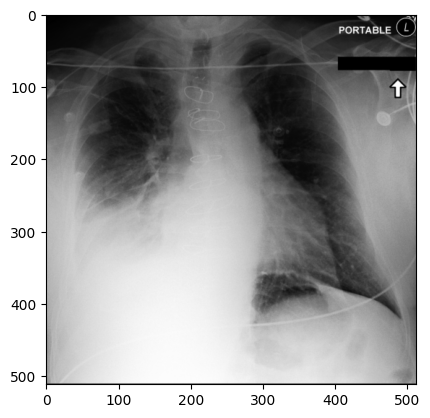

In [765]:
auc, task_aucs, task_outputs, task_targets = valid_test_epoch("test", 0, model, model_name, 
                                                              "cuda", data_loader, 
                                                              torch.nn.BCEWithLogitsLoss(), 
                                                              num_classes=8, use_cutmix=True)

In [973]:
auc, task_aucs, task_outputs, task_targets = valid_test_epoch("test", 0, model, model_name, 
                                                              "cuda", data_loader, 
                                                              torch.nn.BCEWithLogitsLoss(), 
                                                              num_classes=8, use_crop=True,
                                                              identifier_file = original_datasets["mimic"].csv['dicom_id'], 
                                                              mask_file=df_mask, 
                                                              mask_concept="dicom_id", 
                                                             resolution=224)

  0%|                                                                                                                  | 0/12114 [00:00<?, ?it/s]

torch.Size([1, 512, 512])


ValueError: not enough values to unpack (expected 3, got 2)

In [785]:
for samples in data_loader: 
    images = samples['img']
    break

In [787]:
images.size()

torch.Size([8, 1, 512, 512])

In [798]:
xmin,ymin,xmax,ymax = 80, 95, 421, 395

In [799]:
resolution = 512

In [813]:
image_post = torchvision.transforms.functional.crop(images[0], top=xmin, left=ymin, 
                                              height=xmax-xmin, width=ymax-ymin)
image_post = torchvision.transforms.functional.center_crop(image_post, output_size=resolution)

In [816]:
torch.cat((image_post, image_post)).size()

torch.Size([2, 512, 512])